In [25]:
from google.colab import drive
drive.mount('/content/drive')                                                                                                                                                                                                                       

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
%ls -a

./  ../  .config/  drive/  LightGBM/  sample_data/


In [2]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

Cloning into 'LightGBM'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 15018 (delta 52), reused 53 (delta 24), pack-reused 14920
Receiving objects: 100% (15018/15018), 10.48 MiB | 8.35 MiB/s, done.
Resolving deltas: 100% (10808/10808), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 5.18 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'
/content/LightGBM
-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler

In [3]:
#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2019-11-26 12:01:19--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2019-11-26 12:01:20--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://ayera.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2019-11-26 12:01:20--  https://ayera.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving ayera.dl.sourc

In [26]:
!pip install optuna
!pip install joblib
!pip install catboost
!pip install six
#!pip --no-cache-dir install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"
#!pip install lightgbm --install-option=--GPU
#!sudo pip --no-cache-dir install -I lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from catboost import Pool
from catboost import CatBoost
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import csv
import matplotlib.pyplot as plt
from scipy.spatial.distance import correlation
import numpy as np
import pandas as pd
#from multiprocessing import Pool, Value, Array
import multiprocessing as multi
from joblib import Parallel, delayed
import talib as ta
from datetime import datetime, timedelta, timezone
import sklearn.metrics
from sklearn.model_selection import train_test_split
from functools import partial
import optuna
import joblib
from joblib import Parallel, delayed
import time
import random

In [0]:
class OneMinData:
    def initialize(self):
        self.func_dict = {}  # key = [func_name + term], val = (function object, term)
        self.index_data_dict = {}  # key= [func_name + term]], val = [index data]
        self.unix_time = []
        self.dt = []
        self.open = []
        self.high = []
        self.low = []
        self.close = []
        self.open_change = []
        self.high_change = []
        self.low_change = []
        self.close_change = []
        self.size = []
        self.future_side = []

    def cut_data(self, num_data):
        for k in self.index_data_dict:
            self.index_data_dict[k] = self.index_data_dict[k][-num_data:]
        self.unix_time = self.unix_time[-num_data:]
        self.dt = self.dt[-num_data:]
        self.open = self.open[-num_data:]
        self.high = self.high[-num_data:]
        self.low = self.low[-num_data:]
        self.close = self.close[-num_data:]
        self.open_change = self.open_change[-num_data:]
        self.high_change = self.high_change[-num_data:]
        self.low_change = self.low_change[-num_data:]
        self.close_change = self.close_change[-num_data:]
        self.size = self.size[-num_data:]
        self.future_side = self.future_side[-num_data:]

    def cut_data2(self, from_ind, to_ind):
        for k in self.index_data_dict:
            self.index_data_dict[k] = self.index_data_dict[k][from_ind:to_ind]
        self.unix_time = self.unix_time[from_ind:to_ind]
        self.dt = self.dt[from_ind:to_ind]
        self.open = self.open[from_ind:to_ind]
        self.high = self.high[from_ind:to_ind]
        self.low = self.low[from_ind:to_ind]
        self.close = self.close[from_ind:to_ind]
        self.open_change = self.open_change[from_ind:to_ind]
        self.high_change = self.high_change[from_ind:to_ind]
        self.low_change = self.low_change[from_ind:to_ind]
        self.close_change = self.close_change[from_ind:to_ind]
        self.size = self.size[from_ind:to_ind]
        self.future_side = self.future_side[from_ind:to_ind]

    def del_data(self, num_remain_data):
        if len(self.dt) > num_remain_data:
            for k in self.index_data_dict:
                del self.index_data_dict[k][:-num_remain_data]
            del self.unix_time[:-num_remain_data]
            del self.dt[:-num_remain_data]
            del self.open[:-num_remain_data]
            del self.high[:-num_remain_data]
            del self.low[:-num_remain_data]
            del self.close[:-num_remain_data]
            del self.open_change[:-num_remain_data]
            del self.high_change[:-num_remain_data]
            del self.low_change[:-num_remain_data]
            del self.close_change[:-num_remain_data]
            del self.size[:-num_remain_data]
            del self.future_side[:-num_remain_data]

    def extract_data(self, ex_from, to):
        if len(self.dt) > ex_from:
            for k in self.index_data_dict:
                del self.index_data_dict[k][-ex_from:-to]
            del self.unix_time[-ex_from:-to]
            del self.dt[-ex_from:-to]
            del self.open[-ex_from:-to]
            del self.high[-ex_from:-to]
            del self.low[-ex_from:-to]
            del self.close[-ex_from:-to]
            del self.open_change[-ex_from:-to]
            del self.high_change[-ex_from:-to]
            del self.low_change[-ex_from:-to]
            del self.close_change[-ex_from:-to]
            del self.size[-ex_from:-to]
            del self.future_side[-ex_from:-to]

    def add_and_pop(self, unix_time, dt, open, high, low, close, size):
        self.unix_time.append(unix_time)
        self.unix_time.pop(0)
        self.dt.append(dt)
        self.dt.pop(0)
        self.open.append(open)
        self.open.pop(0)
        self.high.append(high)
        self.high.pop(0)
        self.low.append(low)
        self.low.pop(0)
        self.close.append(close)
        self.close.pop(0)
        self.open_change.append(open)
        self.open_change.pop(0)
        self.high_change.append(high)
        self.high_change.pop(0)
        self.low_change.append(low)
        self.low_change.pop(0)
        self.close_change.append(close)
        self.close_change.pop(0)
        self.size.append(size)
        self.size.pop(0)

In [0]:

class OneMinMarketData:
    @classmethod
    def initialize_for_bot(cls, num_term, from_ind, to_ind, kijun_val, kijun_period):
        cls.num_term = num_term
        cls.kijun_val = kijun_val
        cls.kijun_period = kijun_period
        cls.term_list = cls.generate_term_list(num_term)
        cls.ohlc = cls.read_from_csv('/content/drive/My Drive/mex_data.csv')
        cls.ohlc.cut_data2(from_ind, to_ind)
        cls.__generate_all_func_dict()
        cls.__calc_all_index_dict()
        
    @classmethod
    def update_for_bot(cls):
        cls.__calc_all_index()
        

    @classmethod
    def read_from_csv(cls, file_name):
        ohlc = OneMinData()
        ohlc.initialize()
        df = pd.read_csv(file_name)
        ohlc.dt = list(map(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'), list(df['dt'])))
        ohlc.unix_time = list(df['timestamp'])
        ohlc.open = list(df['open'])
        ohlc.high = list(df['high'])
        ohlc.low = list(df['low'])
        ohlc.close = list(df['close'])
        ohlc.size = list(df['volume'])
        return ohlc
    
    
    @classmethod
    def write_all_func_dict(cls):
        with open('/content/drive/My Drive/Model/bpsp_cols.csv', 'w') as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerow(list(cls.ohlc.func_dict.keys()))
        print('completed write bpsp columns')
        
        
    @classmethod
    def read_func_dict(cls):
        #read from func / term list
        cols = []
        with open('/content/drive/My Drive/Model/bpsp_cols.csv', 'r') as f:
            reader = csv.reader(f)
            for r in reader:
                cols.append(r)
        #copy matched key func val
        func_obj= {}
        for col in cols[0]:
            if col not in ['open', 'high', 'low', 'close']:
                func_obj[col] = cls.ohlc.func_dict[col]
        #replace ohlc.func_dict
        cls.ohlc.func_dict = func_obj
    
    
    
    '''
    generate all func / term as a dict
    calc all index as a dict
    generate df from the index data dict
    calc correlation
    remove correlated columns
    renew fund / term dict with non-correlated func / term
    calc index data of the renewed dict
    '''
    
    @classmethod
    def __generate_all_func_dict(cls):
        for term in cls.term_list:
            cls.ohlc.func_dict['ema:'+str(term)] = (OneMinMarketData.calc_ema,term)
            #cls.ohlc.func_dict['ema_kairi:'+str(term)] = (OneMinMarketData.calc_ema_kairi,term)
            #cls.ohlc.func_dict['ema_gra:'+str(term)] = (OneMinMarketData.calc_ema_gra,term)
            cls.ohlc.func_dict['dema:'+str(term)] = (OneMinMarketData.calc_dema,term)
            #cls.ohlc.func_dict['dema_kairi:'+str(term)] = (OneMinMarketData.calc_dema_kairi,term)
            #cls.ohlc.func_dict['dema_gra:'+str(term)] = (OneMinMarketData.calc_dema_gra,term)
            cls.ohlc.func_dict['momentum:'+str(term)] = (OneMinMarketData.calc_momentum,term)
            cls.ohlc.func_dict['rate_of_change:'+str(term)] = (OneMinMarketData.calc_rate_of_change,term)
            cls.ohlc.func_dict['rsi:'+str(term)] = (OneMinMarketData.calc_rsi,term)
            cls.ohlc.func_dict['williams_R:'+str(term)] = (OneMinMarketData.calc_williams_R,term)
            cls.ohlc.func_dict['beta:'+str(term)] = (OneMinMarketData.calc_beta,term)
            cls.ohlc.func_dict['time_series_forecast:'+str(term)] = (OneMinMarketData.calc_time_series_forecast,term)
            cls.ohlc.func_dict['correl:'+str(term)] = (OneMinMarketData.calc_correl,term)
            cls.ohlc.func_dict['linear_reg:'+str(term)] = (OneMinMarketData.calc_linear_reg,term)
            cls.ohlc.func_dict['linear_reg_angle:'+str(term)] = (OneMinMarketData.calc_linear_reg_angle,term)
            cls.ohlc.func_dict['linear_reg_intercept:'+str(term)] = (OneMinMarketData.calc_linear_reg_intercept,term)
            cls.ohlc.func_dict['linear_reg_slope:'+str(term)] = (OneMinMarketData.calc_linear_reg_slope,term)
            cls.ohlc.func_dict['stdv:'+str(term)] = (OneMinMarketData.calc_stdv,term)
            cls.ohlc.func_dict['var:'+str(term)] = (OneMinMarketData.calc_var,term)
            cls.ohlc.func_dict['adx:'+str(term)] = (OneMinMarketData.calc_adx,term)
            cls.ohlc.func_dict['aroon_os:'+str(term)] = (OneMinMarketData.calc_aroon_os,term)
            cls.ohlc.func_dict['cci:'+str(term)] = (OneMinMarketData.calc_cci,term)
            cls.ohlc.func_dict['dx:'+str(term)] = (OneMinMarketData.calc_dx,term)
            if term >= 10:
                cls.ohlc.func_dict['macd:'+str(term)] = (OneMinMarketData.calc_macd,term)
                cls.ohlc.func_dict['macd_signal:'+str(term)] = (OneMinMarketData.calc_macd_signal,term)
                cls.ohlc.func_dict['macd_hist:'+str(term)] = (OneMinMarketData.calc_macd_hist,term)
                '''
            cls.ohlc.func_dict['makairi_momentum:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_momentum, term)
            cls.ohlc.func_dict['makairi_rate_of_change:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_rate_of_change, term)
            cls.ohlc.func_dict['makairi_rsi:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_rsi, term)
            cls.ohlc.func_dict['makairi_williams_R:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_williams_R, term)
            cls.ohlc.func_dict['makairi_beta:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_beta, term)
            cls.ohlc.func_dict['makairi_time_series_forecast:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_time_series_forecast, term)
            cls.ohlc.func_dict['makairi_correl:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_correl, term)
            cls.ohlc.func_dict['makairi_linear_reg:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_linear_reg, term)
            cls.ohlc.func_dict['makairi_linear_reg_angle:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_linear_reg_angle, term)
            cls.ohlc.func_dict['makairi_linear_reg_intercept:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_linear_reg_intercept, term)
            cls.ohlc.func_dict['makairi_linear_reg_slope:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_linear_reg_slope, term)
            cls.ohlc.func_dict['makairi_stdv:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_stdv, term)
            cls.ohlc.func_dict['makairi_var:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_var, term)
            cls.ohlc.func_dict['makairi_adx:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_adx, term)
            cls.ohlc.func_dict['makairi_aroon_os:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_aroon_os, term)
            cls.ohlc.func_dict['makairi_cci:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_cci, term)
            cls.ohlc.func_dict['makairi_dx:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_dx, term)
            
            cls.ohlc.func_dict['diff_momentum:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_momentum, term)
            cls.ohlc.func_dict['diff_rate_of_change:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_rate_of_change, term)
            cls.ohlc.func_dict['diff_rsi:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_rsi, term)
            cls.ohlc.func_dict['diff_williams_R:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_williams_R, term)
            cls.ohlc.func_dict['diff_beta:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_beta, term)
            cls.ohlc.func_dict['diff_time_series_forecast:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_time_series_forecast, term)
            cls.ohlc.func_dict['diff_correl:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_correl, term)
            cls.ohlc.func_dict['diff_linear_reg:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_linear_reg, term)
            cls.ohlc.func_dict['diff_linear_reg_angle:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_linear_reg_angle, term)
            cls.ohlc.func_dict['diff_linear_reg_intercept:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_linear_reg_intercept, term)
            cls.ohlc.func_dict['diff_linear_reg_slope:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_linear_reg_slope, term)
            cls.ohlc.func_dict['diff_stdv:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_stdv, term)
            cls.ohlc.func_dict['diff_var:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_var, term)
            cls.ohlc.func_dict['diff_adx:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_adx, term)
            cls.ohlc.func_dict['diff_aroon_os:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_aroon_os, term)
            cls.ohlc.func_dict['diff_cci:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_cci, term)
            cls.ohlc.func_dict['diff_dx:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_dx, term)
            '''
        cls.ohlc.func_dict['normalized_ave_true_range:'+str(0)] = (OneMinMarketData.calc_normalized_ave_true_range,0)
        cls.ohlc.func_dict['three_outside_updown:'+str(0)] = (OneMinMarketData.calc_three_outside_updown,0)
        cls.ohlc.func_dict['breakway:'+str(0)] = (OneMinMarketData.calc_breakway,0)
        cls.ohlc.func_dict['dark_cloud_cover:'+str(0)] = (OneMinMarketData.calc_dark_cloud_cover,0)
        cls.ohlc.func_dict['dragonfly_doji:'+str(0)] = (OneMinMarketData.calc_dragonfly_doji,0)
        cls.ohlc.func_dict['updown_sidebyside_white_lines:'+str(0)] = (OneMinMarketData.calc_updown_sidebyside_white_lines,0)
        cls.ohlc.func_dict['haramisen:'+str(0)] = (OneMinMarketData.calc_haramisen,0)
        cls.ohlc.func_dict['hikkake_pattern:'+str(0)] = (OneMinMarketData.calc_hikkake_pattern,0)
        cls.ohlc.func_dict['neck_pattern:'+str(0)] = (OneMinMarketData.calc_neck_pattern,0)
        cls.ohlc.func_dict['upsidedownside_gap_three_method:'+str(0)] = (OneMinMarketData.calc_upsidedownside_gap_three_method,0)
        cls.ohlc.func_dict['sar:'+str(0)] = (OneMinMarketData.calc_sar,0)
        cls.ohlc.func_dict['bop:'+str(0)] = (OneMinMarketData.calc_bop,0)
        
        
    @classmethod
    def __calc_all_index_dict(cls):
        print('calculating all index dict')
        start_time = time.time()

        #cls.calc_ohlc_change()

        for k in cls.ohlc.func_dict:
            if int(k.split(':')[1]) > 0:
                if k.split('_')[0] != 'makairi' and k.split('_')[0] != 'diff' and  k.split(':')[0] not in ['ema_kairi', 'ema_gra', 'dema_kairi', 'dema_gra']:
                    cls.ohlc.index_data_dict[k] = cls.ohlc.func_dict[k][0](cls.ohlc.func_dict[k][1])
            else:
                cls.ohlc.index_data_dict[k] = cls.ohlc.func_dict[k][0]()
        print('completed non makairi diff index. time=', time.time() - start_time)

        start_time = time.time()
        for k in cls.ohlc.func_dict:
            if k.split('_')[0] == 'makairi':
                data = cls.ohlc.func_dict[k][1](cls.ohlc.func_dict[k][2])
                cls.ohlc.index_data_dict[k] = cls.ohlc.func_dict[k][0](data, cls.ohlc.func_dict[k][2])
            elif k.split('_')[0] == 'diff':
                data = cls.ohlc.func_dict[k][1](cls.ohlc.func_dict[k][2])
                cls.ohlc.index_data_dict[k] = cls.ohlc.func_dict[k][0](data)

        cls.ohlc.future_side = cls.calc_future_side()
        print('completed calc makairi diff index. time=', time.time() - start_time)

            
            
    @classmethod
    def genrate_df_from_dict(cls):
        start_time = time.time()
        cut_size = cls.term_list[-1] + 1
        end = len(cls.ohlc.close) - cls.kijun_period #due to bpsp
        OneMinMarketData.ohlc.index_data_dict['dt'] = cls.ohlc.dt
        OneMinMarketData.ohlc.index_data_dict['size'] = cls.ohlc.size
        OneMinMarketData.ohlc.index_data_dict['close'] = cls.ohlc.close
        df = pd.DataFrame(OneMinMarketData.ohlc.index_data_dict)
        '''
        df = df.assign(dt=cls.ohlc.dt)
        df = df.assign(open=cls.ohlc.open)
        df = df.assign(high=cls.ohlc.high)
        df = df.assign(low=cls.ohlc.low)
        df = df.assign(close=cls.ohlc.close)
        df = df.assign(open_change=cls.ohlc.open_change)
        df = df.assign(high_change=cls.ohlc.high_change)
        df = df.assign(low_change=cls.ohlc.low_change)
        df = df.assign(close_change=cls.ohlc.close_change)
        df = df.assign(size=cls.ohlc.size)
        '''
        df = df.iloc[cut_size:end] 
        #df['future_side'] = cls.ohlc.future_side[cut_size:]
        df = df.assign(future_side=cls.ohlc.future_side[cut_size:])
        print('completed generate df from dict. time=', time.time() - start_time)
        return df


    @classmethod
    def remove_cols_contains_nan(cls,  df):
        start_time = time.time()
        remove_cols = []
        tmp = df.copy()
        for col in tmp.columns:
            for ind,d in enumerate(tmp[col]):
                if str(d) =='nan':
                    remove_cols.append(col)
                    break
        if len(remove_cols) > 0:
            df.drop(remove_cols, axis=1, inplace=True)
            print('removed ', len(remove_cols), ' cols contains nan.')
        print('completed remove cols contains nan. time=', time.time() - start_time)
        return df
        
    @classmethod
    def remove_cols_contains_nan2(cls, df):
        start_time = time.time()
        pre_n = len(df.columns)
        after_n = len(df.dropna(axis = 1, how = 'any').columns)
        print('removed ', pre_n - after_n, 'cols contains nan.')
        print('completed remove cols contains nan. time=', time.time() - start_time)
        return df.dropna(axis = 1, how = 'any')

    @classmethod
    def __calc_all_index(cls):
        start_time = time.time()
        cls.ohlc.ave_price = cls.calc_ave_price(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        for term in cls.term_list:
            cls.ohlc.ema[term] = cls.calc_ema(term, cls.ohlc.close)
            cls.ohlc.ema_kairi[term] = cls.calc_ema_kairi(cls.ohlc.close, cls.ohlc.ema[term])
            cls.ohlc.ema_gra[term] = cls.calc_ema_gra(cls.ohlc.ema[term])
            cls.ohlc.dema[term] = cls.calc_dema(term, cls.ohlc.close)
            cls.ohlc.dema_kairi[term] = cls.calc_dema_kairi(cls.ohlc.close, cls.ohlc.dema[term])
            cls.ohlc.dema_gra[term] = cls.calc_dema_gra(cls.ohlc.dema[term])
            cls.ohlc.momentum[term] = cls.calc_momentum(term, cls.ohlc.close)
            cls.ohlc.rate_of_change[term] = cls.calc_rate_of_change(term, cls.ohlc.close)
            cls.ohlc.rsi[term] = cls.calc_rsi(term, cls.ohlc.close)
            cls.ohlc.williams_R[term] = cls.calc_williams_R(term, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
            cls.ohlc.beta[term] = cls.calc_beta(term, cls.ohlc.high, cls.ohlc.low)
            cls.ohlc.tsf[term] = cls.calc_time_series_forecast(term, cls.ohlc.close)
            cls.ohlc.correl[term] = cls.calc_correl(term, cls.ohlc.high, cls.ohlc.low)
            cls.ohlc.linear_reg[term] = cls.calc_linear_reg(term, cls.ohlc.close)
            cls.ohlc.linear_reg_angle[term] = cls.calc_linear_reg_angle(term, cls.ohlc.close)
            cls.ohlc.linear_reg_intercept[term] = cls.calc_linear_reg_intercept(term, cls.ohlc.close)
            cls.ohlc.linear_reg_slope[term] = cls.calc_linear_reg_slope(term, cls.ohlc.close)
            cls.ohlc.stdv[term] = cls.calc_stdv(term, cls.ohlc.close)
            cls.ohlc.var[term] = cls.calc_var(term, cls.ohlc.close)
            cls.ohlc.linear_reg_ave[term] = cls.calc_linear_reg(term, cls.ohlc.ave_price)
            cls.ohlc.linear_reg_angle_ave[term] = cls.calc_linear_reg_angle(term, cls.ohlc.ave_price)
            cls.ohlc.linear_reg_intercept_ave[term] = cls.calc_linear_reg_intercept(term, cls.ohlc.ave_price)
            cls.ohlc.linear_reg_slope_ave[term] = cls.calc_linear_reg_slope(term, cls.ohlc.ave_price)
            cls.ohlc.stdv_ave[term] = cls.calc_stdv(term, cls.ohlc.ave_price)
            cls.ohlc.var_ave[term] = cls.calc_var(term, cls.ohlc.ave_price)
            cls.ohlc.adx[term] = cls.calc_adx(term, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
            cls.ohlc.aroon_os[term] = cls.calc_aroon_os(term, cls.ohlc.high, cls.ohlc.low)
            cls.ohlc.cci[term] = cls.calc_cci(term, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
            cls.ohlc.dx[term] = cls.calc_dx(term, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
            if term >= 10:
                cls.ohlc.macd[term], cls.ohlc.macdsignal[term], cls.ohlc.macdhist[term] = cls.calc_macd(cls.ohlc.close, int(float(term) / 2.0), term, int(float(term) / 3.0))
                cls.ohlc.macd[term] = list(cls.ohlc.macd[term])
                cls.ohlc.macdsignal[term] = list(cls.ohlc.macdsignal[term])
                cls.ohlc.macdhist[term] = list(cls.ohlc.macdhist[term])
                cls.ohlc.macd_ave[term], cls.ohlc.macdsignal_ave[term], cls.ohlc.macdhist_ave[term] = cls.calc_macd(cls.ohlc.ave_price, int(float(term) / 2.0), term,int(float(term) / 3.0))
                cls.ohlc.macd_ave[term] = list(cls.ohlc.macd_ave[term])
                cls.ohlc.macdsignal_ave[term] = list(cls.ohlc.macdsignal_ave[term])
                cls.ohlc.macdhist_ave[term] = list(cls.ohlc.macdhist_ave[term])
        cls.ohlc.normalized_ave_true_range = cls.calc_normalized_ave_true_range(cls.ohlc.high, cls.ohlc.low,
                                                                                cls.ohlc.close)
        cls.ohlc.three_outside_updown = cls.calc_three_outside_updown(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low,
                                                                      cls.ohlc.close)
        cls.ohlc.breakway = cls.calc_breakway(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.dark_cloud_cover = cls.calc_dark_cloud_cover(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low,
                                                              cls.ohlc.close)
        cls.ohlc.dragonfly_doji = cls.calc_dragonfly_doji(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.updown_sidebyside_white_lines = cls.calc_updown_sidebyside_white_lines(cls.ohlc.open, cls.ohlc.high,
                                                                                        cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.haramisen = cls.calc_haramisen(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.hikkake_pattern = cls.calc_hikkake_pattern(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.neck_pattern = cls.calc_neck_pattern(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.upsidedownside_gap_three_method = cls.calc_upsidedownside_gap_three_method(cls.ohlc.open,
                                                                                            cls.ohlc.high, cls.ohlc.low,
                                                                                            cls.ohlc.close)
        cls.ohlc.sar = cls.calc_sar(cls.ohlc.high, cls.ohlc.low, 0.02, 0.2)
        cls.ohlc.bop = cls.calc_bop(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        #cls.ohlc.bp, cls.ohlc.sp = cls.calc_pl_ls_points()

        #generate various index
        for term in cls.term_list:
            cls.ohlc.various_makairi['emakairi'+str(term)] = cls.ohlc.ema_kairi[term]
            cls.ohlc.various_makairi['demakairi' + str(term)] = cls.ohlc.dema_kairi[term]
            cls.ohlc.various_diff['emadiff'+str(term)] = cls.ohlc.ema_kairi[term]
            cls.ohlc.various_diff['demadiff' + str(term)] = cls.ohlc.dema_kairi[term]
            cls.ohlc.various_makairi['momkairi' + str(term)] = cls.ohlc.momentum[term]
            cls.ohlc.various_diff['momdiff' + str(term)] = cls.ohlc.momentum[term]
            cls.ohlc.various_makairi['rsikairi' + str(term)] = cls.ohlc.rsi[term]
            cls.ohlc.various_diff['rsidiff' + str(term)] = cls.ohlc.rsi[term]
            cls.ohlc.various_makairi['williams_Rkairi' + str(term)] = cls.ohlc.williams_R[term]
            cls.ohlc.various_diff['williams_Rdiff' + str(term)] = cls.ohlc.williams_R[term]
            cls.ohlc.various_makairi['betakairi' + str(term)] = cls.ohlc.beta[term]
            cls.ohlc.various_diff['betadiff' + str(term)] = cls.ohlc.beta[term]
            cls.ohlc.various_makairi['linear_regkairi' + str(term)] = cls.ohlc.linear_reg[term]
            cls.ohlc.various_diff['linear_regdiff' + str(term)] = cls.ohlc.linear_reg[term]
            cls.ohlc.various_makairi['linear_reg_slopekairi' + str(term)] = cls.ohlc.linear_reg_slope[term]
            cls.ohlc.various_diff['linear_reg_slopediff' + str(term)] = cls.ohlc.linear_reg_slope[term]
            cls.ohlc.various_makairi['adxkairi' + str(term)] = cls.ohlc.adx[term]
            cls.ohlc.various_diff['adxdiff' + str(term)] = cls.ohlc.adx[term]
            cls.ohlc.various_makairi['aroon_oskairi' + str(term)] = cls.ohlc.aroon_os[term]
            cls.ohlc.various_diff['aroon_osdiff' + str(term)] = cls.ohlc.aroon_os[term]
            cls.ohlc.various_makairi['ccikairi' + str(term)] = cls.ohlc.cci[term]
            cls.ohlc.various_diff['ccidiff' + str(term)] = cls.ohlc.cci[term]
            if term >= 10:
                cls.ohlc.various_makairi['macdkairi' + str(term)] = cls.ohlc.macd[term]
                cls.ohlc.various_diff['macddiff' + str(term)] = cls.ohlc.macd[term]
                cls.ohlc.various_makairi['macdsignalkairi' + str(term)] = cls.ohlc.macdsignal[term]
                cls.ohlc.various_diff['macdsignaldiff' + str(term)] = cls.ohlc.macdsignal[term]
                cls.ohlc.various_makairi['macdhistkairi' + str(term)] = cls.ohlc.macdhist[term]
                cls.ohlc.various_diff['macdhistdiff' + str(term)] = cls.ohlc.macdhist[term]
        cls.ohlc.future_side = cls.calc_future_side()
        print('calc all index1 time={}'.format(time.time() - start_time))


    @classmethod
    def generate_raw_df(cls):
        def __change_dict_key(d, col_name):
            newd = dict(map(lambda k: (col_name + str(k), d[k][:]), d.keys()))
            return newd
        '''data_dict = {'dt':cls.ohlc.dt[:], 'open':cls.ohlc.open[:], 'high':cls.ohlc.high[:],'low':cls.ohlc.low[:],
                    'close':cls.ohlc.close[:], 'size':cls.ohlc.size[:], 'normalized_ave_true_range':cls.ohlc.normalized_ave_true_range[:],
                    'sar':cls.ohlc.sar[:],'bop':cls.ohlc.bop[:]}'''
        data_dict = {'dt': cls.ohlc.dt[:], 'open': cls.ohlc.open[:], 'high': cls.ohlc.high[:], 'low': cls.ohlc.low[:],
                     'close': cls.ohlc.close[:], 'size': cls.ohlc.size[:],
                     'normalized_ave_true_range': cls.ohlc.normalized_ave_true_range[:],
                     'three_outside_updown': cls.ohlc.three_outside_updown[:], 'breakway': cls.ohlc.breakway[:],
                     'dark_cloud_cover': cls.ohlc.dark_cloud_cover[:],
                     'dragonfly_doji': cls.ohlc.dragonfly_doji[:],
                     'three_oupdown_sidebyside_white_linesutside_updown': cls.ohlc.updown_sidebyside_white_lines[:],
                     'haramisen': cls.ohlc.haramisen[:], 'haramhikkake_patternisen': cls.ohlc.hikkake_pattern[:],
                     'neck_pattern': cls.ohlc.neck_pattern[:],
                     'upsidedownside_gap_three_method': cls.ohlc.upsidedownside_gap_three_method[:],
                     'sar': cls.ohlc.sar[:], 'bop': cls.ohlc.bop[:]}
        data_dict = {**data_dict, **__change_dict_key(cls.ohlc.ema, 'ema'),
                     **__change_dict_key(cls.ohlc.ema_ave, 'ema_ave'),
                     **__change_dict_key(cls.ohlc.ema_kairi, 'ema_kairi'),
                     **__change_dict_key(cls.ohlc.dema_kairi, 'dema_kairi'),
                     **__change_dict_key(cls.ohlc.ema_gra, 'ema_gra'), **__change_dict_key(cls.ohlc.dema, 'dema'),
                     **__change_dict_key(cls.ohlc.dema_ave, 'dema_ave'),
                     **__change_dict_key(cls.ohlc.dema_gra, 'dema_gra'),
                     **__change_dict_key(cls.ohlc.midprice, 'midprice'),
                     **__change_dict_key(cls.ohlc.momentum, 'momentum'),
                     **__change_dict_key(cls.ohlc.momentum_ave, 'momentum_ave'),
                     **__change_dict_key(cls.ohlc.rate_of_change, 'rate_of_change'),
                     **__change_dict_key(cls.ohlc.rsi, 'rsi'), **__change_dict_key(cls.ohlc.williams_R, 'williams_R'),
                     **__change_dict_key(cls.ohlc.beta, 'beta'), **__change_dict_key(cls.ohlc.tsf, 'tsf'),
                     **__change_dict_key(cls.ohlc.correl, 'correl'),
                     **__change_dict_key(cls.ohlc.linear_reg, 'linear_reg'),
                     **__change_dict_key(cls.ohlc.linear_reg_angle, 'linear_reg_angle'),
                     **__change_dict_key(cls.ohlc.linear_reg_intercept, 'linear_reg_intercept'),
                     **__change_dict_key(cls.ohlc.linear_reg_slope, 'linear_reg_slope'),
                     **__change_dict_key(cls.ohlc.stdv, 'stdv'), **__change_dict_key(cls.ohlc.var, 'var'),
                     **__change_dict_key(cls.ohlc.linear_reg_ave, 'linear_reg_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_angle_ave, 'linear_reg_angle_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_intercept_ave, 'linear_reg_intercept_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_slope_ave, 'linear_reg_slope_ave'),
                     **__change_dict_key(cls.ohlc.stdv_ave, 'stdv_ave'),
                     **__change_dict_key(cls.ohlc.var_ave, 'var_ave'), **__change_dict_key(cls.ohlc.adx, 'adx'),
                     **__change_dict_key(cls.ohlc.aroon_os, 'aroon_os'),
                     **__change_dict_key(cls.ohlc.cci, 'cci'), **__change_dict_key(cls.ohlc.dx, 'dx'),
                     **__change_dict_key(cls.ohlc.macd, 'macd'),
                     **__change_dict_key(cls.ohlc.macdsignal, 'macdsignal'),
                     **__change_dict_key(cls.ohlc.macdhist, 'macdhist'),
                     **__change_dict_key(cls.ohlc.macd_ave, 'macd_ave'),
                     **__change_dict_key(cls.ohlc.macdsignal_ave, 'macdsignal_ave'),
                     **__change_dict_key(cls.ohlc.macdhist_ave, 'macdhist_ave'),
                     ** __change_dict_key(cls.ohlc.various_makairi, 'various_makairi'),
                     **__change_dict_key(cls.ohlc.various_diff, 'various_diff')}
        df = pd.DataFrame.from_dict(data_dict)
        return df

    '''
    dema, adx, macdはnum_term * 2くらいnanが発生する
    print(df.isnull().sum())
    '''

    @classmethod
    def generate_df(cls):
        def __change_dict_key(d, col_name):
            newd = dict(map(lambda k: (col_name + '_'+str(k), d[k][cut_size:end]), d.keys()))
            return newd

        start_time = time.time()
        cut_size = cls.term_list[-1] * 2
        end = len(cls.ohlc.close) - 10 #remove last 700min data as future bp / sp maybe not precise in
        data_dict = {'dt': cls.ohlc.dt[cut_size:end], 'open': cls.ohlc.open[cut_size:end],
                     'high': cls.ohlc.high[cut_size:end], 'low': cls.ohlc.low[cut_size:end],
                     'close': cls.ohlc.close[cut_size:end], 'size': cls.ohlc.size[cut_size:end],
                     'normalized_ave_true_range': cls.ohlc.normalized_ave_true_range[cut_size:end],
                     'three_outside_updown': cls.ohlc.three_outside_updown[cut_size:end],
                     'breakway': cls.ohlc.breakway[cut_size:end],
                     'dark_cloud_cover': cls.ohlc.dark_cloud_cover[cut_size:end],
                     'dragonfly_doji': cls.ohlc.dragonfly_doji[cut_size:end],
                     'three_oupdown_sidebyside_white_linesutside_updown': cls.ohlc.updown_sidebyside_white_lines[
                                                                          cut_size:end],
                     'haramisen': cls.ohlc.haramisen[cut_size:end],
                     'haramhikkake_patternisen': cls.ohlc.hikkake_pattern[cut_size:end],
                     'neck_pattern': cls.ohlc.neck_pattern[cut_size:end],
                     'upsidedownside_gap_three_method': cls.ohlc.upsidedownside_gap_three_method[cut_size:end],
                     'sar': cls.ohlc.sar[cut_size:end], 'bop': cls.ohlc.bop[cut_size:end]}
        data_dict = {**data_dict, **__change_dict_key(cls.ohlc.ema, 'ema'),
                     **__change_dict_key(cls.ohlc.ema_ave, 'ema_ave'),
                     **__change_dict_key(cls.ohlc.ema_kairi, 'ema_kairi'),
                     **__change_dict_key(cls.ohlc.dema_kairi, 'dema_kairi'),
                     **__change_dict_key(cls.ohlc.ema_gra, 'ema_gra'), **__change_dict_key(cls.ohlc.dema, 'dema'),
                     **__change_dict_key(cls.ohlc.dema_ave, 'dema_ave'),
                     **__change_dict_key(cls.ohlc.dema_gra, 'dema_gra'),
                     **__change_dict_key(cls.ohlc.midprice, 'midprice'),
                     **__change_dict_key(cls.ohlc.momentum, 'momentum'),
                     **__change_dict_key(cls.ohlc.momentum_ave, 'momentum_ave'),
                     **__change_dict_key(cls.ohlc.rate_of_change, 'rate_of_change'),
                     **__change_dict_key(cls.ohlc.rsi, 'rsi'), **__change_dict_key(cls.ohlc.williams_R, 'williams_R'),
                     **__change_dict_key(cls.ohlc.beta, 'beta'), **__change_dict_key(cls.ohlc.tsf, 'tsf'),
                     **__change_dict_key(cls.ohlc.correl, 'correl'),
                     **__change_dict_key(cls.ohlc.linear_reg, 'linear_reg'),
                     **__change_dict_key(cls.ohlc.linear_reg_angle, 'linear_reg_angle'),
                     **__change_dict_key(cls.ohlc.linear_reg_intercept, 'linear_reg_intercept'),
                     **__change_dict_key(cls.ohlc.linear_reg_slope, 'linear_reg_slope'),
                     **__change_dict_key(cls.ohlc.stdv, 'stdv'), **__change_dict_key(cls.ohlc.var, 'var'),
                     **__change_dict_key(cls.ohlc.linear_reg_ave, 'linear_reg_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_angle_ave, 'linear_reg_angle_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_intercept_ave, 'linear_reg_intercept_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_slope_ave, 'linear_reg_slope_ave'),
                     **__change_dict_key(cls.ohlc.stdv_ave, 'stdv_ave'),
                     **__change_dict_key(cls.ohlc.var_ave, 'var_ave'), **__change_dict_key(cls.ohlc.adx, 'adx'),
                     **__change_dict_key(cls.ohlc.aroon_os, 'aroon_os'),
                     **__change_dict_key(cls.ohlc.cci, 'cci'), **__change_dict_key(cls.ohlc.dx, 'dx'),
                     **__change_dict_key(cls.ohlc.macd, 'macd'),
                     **__change_dict_key(cls.ohlc.macdsignal, 'macdsignal'),
                     **__change_dict_key(cls.ohlc.macdhist, 'macdhist'),
                     **__change_dict_key(cls.ohlc.macd_ave, 'macd_ave'),
                     **__change_dict_key(cls.ohlc.macdsignal_ave, 'macdsignal_ave'),
                     **__change_dict_key(cls.ohlc.macdhist_ave, 'macdhist_ave'),
                     **__change_dict_key(cls.ohlc.various_makairi, 'various_makairi'),
                     **__change_dict_key(cls.ohlc.various_diff, 'various_diff')}
        data_dict['bpsp'] = cls.ohlc.bpsp[cut_size:end]
#        data_dict['bp'] = cls.ohlc.bp[cut_size:end]
#        data_dict['sp'] = cls.ohlc.sp[cut_size:end]
        df = pd.DataFrame.from_dict(data_dict)
        return df

    @classmethod
    def generate_term_list(cls, num):
        term_list = []
        category_n = [5, 50, 200]
        term_list.extend(list(np.round(np.linspace(category_n[0], category_n[0] * num, num))))
        term_list.extend(list(np.round(np.linspace(category_n[1] + (category_n[0] * num),category_n[1] + (category_n[0] * num) + category_n[1] * num), num)))
        term_list.extend(list(np.round(np.linspace(category_n[2] + category_n[1] + (category_n[0] * num) + (category_n[1] * num),category_n[2] + (category_n[1] * num) + category_n[2] * num), num)))
        return list(map(int, term_list))

    @classmethod
    def detect_max_term(cls):
        max_term = 0
        cols = []
        with open("./Model/bpsp_cols.csv", "r") as f:
            reader = csv.reader(f)
            for r in reader:
                cols.append(r)
        for col in cols[0]:
            if col not in ['open', 'high', 'low', 'close']:
                if max_term < int(col.split(':')[1]):
                    max_term = int(col.split(':')[1])
        return max_term


    @classmethod
    def calc_ohlc_change(cls):
        cls.ohlc.open_change.append(0)
        cls.ohlc.high_change.append(0)
        cls.ohlc.low_change.append(0)
        cls.ohlc.close_change.append(0)
        for i in range(len(cls.ohlc.close)-1):
            close = cls.ohlc.close[i]
            cls.ohlc.open_change.append(round(cls.ohlc.open[i+1] / close,5))
            cls.ohlc.high_change.append(round(cls.ohlc.high[i + 1] / close, 5))
            cls.ohlc.low_change.append(round(cls.ohlc.low[i + 1] / close, 5))
            cls.ohlc.close_change.append(round(cls.ohlc.close[i + 1] / close,5))


     #kairi of data
    @classmethod
    def generate_makairi(cls, data, ma_term):
        ma = np.array(list(ta.MA(np.array(data, dtype='f8'), timeperiod=ma_term)),dtype='f8')
        return list(map(lambda c, e: (c - e) / e, np.array(data, dtype='f8'), ma))

    @classmethod
    def generate_diff(cls, data):
        return list(ta.ROC(np.array(data, dtype='f8'), timeperiod=1))
        #return [0] + list(np.diff(np.array(data, dtype='f8')))


    #points of long can get pt before lc and vice versa
    @classmethod
    def calc_pl_ls_points(cls):  # both pl and ls should be plus val as abs
        buy_points = []
        sell_points = []
        print(cls.pt)
        for i in range(len(cls.ohlc.close)):
            entry_p = cls.ohlc.open[i]
            j = 0
            while True: #loop for bp
                if i+ j < len(cls.ohlc.close):
                    if -cls.lc >= cls.ohlc.low[i+j] - entry_p: #lc before pt for buy
                        buy_points.append(0)
                        break
                    elif cls.pt <= cls.ohlc.high[i+j] - entry_p:
                        buy_points.append(1)
                        break
                else:
                    buy_points.append(0)
                    break
                j +=1
            j = 0
            while True: #loop for sp
                if i+ j < len(cls.ohlc.close):
                    if -cls.lc >= entry_p - cls.ohlc.high[i+j]: #lc before pt for buy
                        sell_points.append(0)
                        break
                    elif cls.pt <= entry_p - cls.ohlc.low[i+j]:
                        sell_points.append(1)
                        break
                else:
                    sell_points.append(0)
                    break
                j +=1
        return buy_points, sell_points
    
    
    #higher pl in next 1m for bp sp
    @classmethod
    def calc_bpsp_points(cls):
        bpsp = [] #0: buy, 1:sell
        for i in range(1, len(cls.ohlc.close)):
            if cls.ohlc.close[i] - cls.ohlc.close[i-1] > cls.ohlc.close[i-1] - cls.ohlc.close[i]:
                bpsp.append(1)
            else:
                bpsp.append(0)
        bpsp.append(None)
        return bpsp
        

    @classmethod
    def calc_bpsp_points2(cls):
        bp = []
        sp = []
        for i in range(len(cls.ohlc.close) - cls.kijun_period):
            flg_buy = 0
            flg_sell = 0
            entry_p = cls.ohlc.close[i]
            j = 0
            for j in range(cls.kijun_period):
                if i+j < len(cls.ohlc.close):
                    if cls.ohlc.close[i+j] - entry_p >= cls.kijun_val:
                        flg_buy = 1
                    if entry_p - cls.ohlc.close[i+j] >= cls.kijun_val:
                        flg_sell = 1
                else:
                    break
            bp.append(flg_buy)
            sp.append(flg_sell)
        return bp, sp


    @classmethod
    def calc_future_side(cls):
        future_side = []
        num_buy = 0
        num_sell = 0
        num_no = 0
        num_both = 0
        for i in range(len(cls.ohlc.close) - cls.kijun_period):
            buy_max = 0
            sell_max = 0
            entry_p = cls.ohlc.close[i]
            for j in range(cls.kijun_period):
                buy_max = max(buy_max, cls.ohlc.close[i+j] - entry_p)
                sell_max = max(sell_max, entry_p - cls.ohlc.close[i+j])
            if buy_max >= cls.kijun_val and sell_max >= cls.kijun_val:
                future_side.append('both')
                num_both += 1
            elif buy_max >= cls.kijun_val and sell_max < cls.kijun_val:
                future_side.append('buy')
                num_buy += 1
            elif buy_max < cls.kijun_val and sell_max >= cls.kijun_val:
                future_side.append('sell')
                num_sell += 1
            elif buy_max < cls.kijun_val and sell_max < cls.kijun_val:
                future_side.append('no')
                num_no += 1

        print('future_side allocation in Market Data:')
        tsum = float(len(future_side))
        print('no:', round(float(num_no) / tsum, 4), 'buy:', round(float(num_buy) / tsum, 4), 'sell:', round(float(num_sell) / tsum, 4), 'both:', round(float(num_both) / tsum, 4))
        return future_side

    @classmethod
    def remove_all_correlated_cols(cls, df, corr_kijun):
        def remove_high_corr_cols(df, col_name, kijun):
            remove_cols = []
            num_corr = 0
            for i in range(len(df.columns) - 1):
                if df.columns[i] != col_name and df.columns[i] != 'dt':
                    corr = df[col_name].corr(df[df.columns[i]])
                    if corr > kijun and df.columns[i] not in ['open', 'high', 'low', 'close', 'size', 'future_side']:
                        num_corr += 1
                        remove_cols.append(df.columns[i])
            if len(remove_cols) > 0:
                df.drop(remove_cols, axis = 1, inplace = True)
                print('removed '+str(num_corr) + 'cols', ' total cols='+str(len(df.columns)))
            print('completed remove all correlated cols. time=', time.time() - start_time)
            return df

        nt= 0
        df2 = df.copy()
        while True:
            if len(df2.columns) <= nt:
                print('kita')
                break
            elif df2.columns[nt] != 'dt':
                df2 = remove_high_corr_cols(df2, df2.columns[nt], corr_kijun)
            nt += 1
        return df2

    
    @classmethod
    def remove_all_correlated_cols2(self, df, corr_kijun):
        print('removing all correlated columns..')
        df2 = df.copy()
        df3 = df.copy()
        df2.drop(['dt'], axis=1, inplace=True)
        #corrs = np.corrcoef(np.array(df2).transpose())
        corrs = np.corrcoef(np.array(df2))
        remove_cols = []
        cols = list(df2.columns)
        for cor in corrs:
            for i in range(len(cor)):
                if cor[i] != 1.0 and cor[i] > corr_kijun:
                    if cols[i] not in remove_cols and cols[i] not in ['open', 'high', 'low', 'close', 'size', 'future_side']:
                        remove_cols.append(cols[i])
        df3.drop(remove_cols, axis=1, inplace=True)
        print('removed '+str(len(remove_cols))+' colums')
        print(remove_cols)
        return df3, corrs
    
    @classmethod
    def remove_all_correlated_cols3(self, df, corr_kijun):
        print('removing all correlated columns..')
        start_time = time.time()
        df2 = df.copy()
        df3 = df.copy()
        df2.drop(['dt','future_side'], axis=1, inplace=True)
        corrs = np.corrcoef(np.array(df2).transpose())

        # 1. 0番目から0.9以上のindexを検索
        def check_corr_kijun(cor, cor_ind, kijun):
            rem = []
            for i, c in enumerate(cor):
                if c >= kijun and i != cor_ind:
                    rem.append(i)
            return rem

        tmp_remo = []
        for i, cor in enumerate(corrs):
            if i not in tmp_remo:  # 3. 該当indexを除いて次のindexを対象に1の操作を実行
                # 2. 該当したindexをtmp_remoに記録
                tmp_remo.extend(check_corr_kijun(cor, i, corr_kijun))
        
        cols = list(df2.columns)
        for col in cols:
            cor = 1 - correlation(df2['close'], df2[col])
            if cor >= corr_kijun:
                tmp_remo.extend(col)

        # 4. tmp_remoに記録されたindexのcolumnをdfから削除
        target_col = []
        cols = list(df2.columns)
        for tr in tmp_remo:
            target_col.append(cols[tr])
        excludes = ['dt', 'open', 'high', 'low', 'close', 'close_change', 'dt', 'future_side']
        for ex in excludes:
            if ex in target_col:
                target_col.remove(ex)
        df3.drop(target_col, axis=1, inplace=True)
        print('removed ' + str(len(target_col)) + ' colums', 'remaining col=' + str(len(df3.columns)))
        print('completed remove all correlated cols3. time=', time.time() - start_time)
        return df3, corrs
                    

    @classmethod
    def remove_all_correlated_cols4(cls, df, corr_kijun):
        print('removing all correlated columns..')
        start_time = time.time()
        dff = df.copy()
        dff.drop(['dt','future_side'], axis=1, inplace=True)
        cols = list(dff.columns)
        df_res = df.copy()
        corr_matrix = np.corrcoef(np.array(dff).transpose())
        df_new = pd.DataFrame(data=corr_matrix, index=cols, columns=cols, dtype='float')
        upper = df_new.where(np.triu(np.ones(df_new.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > corr_kijun)]
        excludes = ['dt', 'open', 'high', 'low', 'close', 'close_change', 'future_side', 'size']
        for ex in excludes:
            if ex in to_drop:
                to_drop.remove(ex)
        df_res.drop(to_drop, axis=1, inplace=True)
        print('removed ' + str(len(to_drop)) + ' colums', 'remaining col=' + str(len(df_res.columns)))
        print('completed remove all correlated cols4. time=', time.time() - start_time)
        return df_res


    @classmethod
    def remove_price_dependent_cols(cls, df):
        print('removing all price dependent columns..')
        max_ind = np.array(list(df['close'])).argmax()
        min_ind = np.array(list(df['close'])).argmin()
        cols = list(df.columns)
        target_cols = []
        for col in cols:
            if abs(np.array(df[col]).argmax() - max_ind) <= 10 and abs(np.array(df[col]).argmin() - min_ind) <= 10:
                target_cols.append(col)
        excludes = ['dt', 'open', 'high', 'low', 'close', 'close_change', 'future_side']
        for ex in excludes:
            if ex in target_cols:
                target_cols.remove(ex)
        df.drop(target_cols, axis=1, inplace=True)
        print('removed ' + str(len(target_cols)) + ' colums', 'remaining col=' + str(len(df.columns)))
        return df

    @classmethod
    def remove_price_dependent_cols2(cls, df, corr_kijun):
        print('removing all price dependent columns..')
        dff = df.copy()
        df_res = df.copy()
        dff.drop(['dt','future_side'], axis=1, inplace=True)
        cols = list(dff.columns)
        to_drop = []
        for col in cols:
            corr = np.corrcoef(dff['close'], dff[col], rowvar=False)[1][0]
            if corr > corr_kijun:
                to_drop.append(col)
        excludes = ['dt', 'open', 'high', 'low', 'close', 'future_side', 'size']
        for ex in excludes:
            if ex in to_drop:
                to_drop.remove(ex)
        df_res.drop(to_drop, axis=1, inplace=True)
        print('removed ' + str(len(to_drop)) + ' colums', 'remaining col=' + str(len(df.columns)))
        return df_res



    @classmethod
    def calc_hist_high(cls, term, high, close):
        res = []
        for i in range(len(high) - term):
            res.append((max(high[i:i + term]) / close[i]) - 1)
        return res

    @classmethod
    def calc_hist_low(cls, term, low, close):
        res = []
        for i in range(len(low) - term):
            res.append((min(low[i:i + term]) / close[i]) - 1)
        return res

    @classmethod
    def calc_high_kairi(cls, term):
        #res = [0 * term]
        ind = list(range(len(cls.ohlc.high)-term))
        #max_val = list(map(lambda i: max(cls.ohlc.high[i-term:i]), ind)
        #list(map(lambda i: cls.ohlc.high[i+term] / max_val[i], list(range(len(cls.ohlc.high))))

    @classmethod
    def calc_ema(cls, term):
        return list(ta.EMA(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    
    @classmethod
    def calc_ema_kairi(cls, term):
        return list(map(lambda c, e: (c - e) / e, np.array(cls.ohlc.close, dtype='f8'), np.array(cls.ohlc.index_data_dict['ema:'+str(term)], dtype='f8')))

    @classmethod
    def calc_dema_kairi(cls, term):
        return list(map(lambda c, d: (c - d) / d, np.array(cls.ohlc.close, dtype='f8'), np.array(cls.ohlc.index_data_dict['dema:'+str(term)], dtype='f8')))

    @classmethod
    def calc_ema_gra(cls, term):
        return list(pd.Series(cls.ohlc.index_data_dict['ema:'+str(term)]).diff())

    @classmethod
    def calc_dema_gra(cls, term):
        return list(pd.Series(cls.ohlc.index_data_dict['dema:'+str(term)]).diff())

    @classmethod
    def calc_dema(cls, term):
        return list(ta.DEMA(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    #termの2倍くらいnanが続く
    @classmethod
    def calc_adx(cls, term):
        return list(
            ta.ADX(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_aroon_os(cls, term):
        return list(ta.AROONOSC(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_cci(cls, term):
        return list(
            ta.CCI(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_dx(cls, term):
        return list(
            ta.DX(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_midprice(cls, term, high, low):
        return list(ta.MIDPRICE(np.array(high, dtype='f8'), np.array(low, dtype='f8'), timeperiod=term))

    
    @classmethod
    def calc_macd(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.ohlc.close, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'), np.array(signalperiod, dtype='i8'))
        return macd
    
    @classmethod
    def calc_macd_signal(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.ohlc.close, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'),
                       np.array(signalperiod, dtype='i8'))
        return signal
    
    @classmethod
    def calc_macd_hist(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist = ta.MACD(np.array(cls.ohlc.close, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'),
                       np.array(signalperiod, dtype='i8'))
        return hist

    @classmethod
    def calc_momentum(cls, term):
        return list(ta.MOM(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_rate_of_change(cls, term):
        return list(ta.ROC(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_rsi(cls, term):
        return list(ta.RSI(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_williams_R(cls, term):
        return list(ta.WILLR(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8'),timeperiod=term))

    @classmethod
    def calc_beta(cls, term):
        return list(ta.BETA(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_time_series_forecast(cls, term):
        return list(ta.TSF(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_correl(cls, term):
        return list(ta.CORREL(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_linear_reg(cls, term):
        return list(ta.LINEARREG(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_linear_reg_angle(cls, term):
        return list(ta.LINEARREG_ANGLE(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_linear_reg_intercept(cls, term):
        return list(ta.LINEARREG_SLOPE(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_linear_reg_slope(cls, term):
        return list(ta.LINEARREG_INTERCEPT(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_stdv(cls, term):
        return list(ta.STDDEV(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term, nbdev=1))

    @classmethod
    def calc_var(cls, term):
        return list(ta.VAR(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term, nbdev=1))

    @classmethod
    def calc_normalized_ave_true_range(cls):
        return list(ta.NATR(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_three_outside_updown(cls):
        return list(ta.CDL3OUTSIDE(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),
                                   np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_breakway(cls):
        return list(ta.CDLBREAKAWAY(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),
                                    np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_dark_cloud_cover(cls):
        return list(ta.CDLDARKCLOUDCOVER(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),
                                 np.array(cls.ohlc.close, dtype='f8'), penetration=0))

    @classmethod
    def calc_dragonfly_doji(cls):
        return list(ta.CDLDRAGONFLYDOJI(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),
                                np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_updown_sidebyside_white_lines(cls):
        return list(
            ta.CDLGAPSIDESIDEWHITE(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),
                                   np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_haramisen(cls):
        return list(ta.CDLHARAMI(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_hikkake_pattern(cls):
        return list(ta.CDLHIKKAKEMOD(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_neck_pattern(cls):
        return list(ta.CDLINNECK(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_sar(cls):
        accelation = 0.02
        maximum = 0.2
        return list(ta.SAR(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(accelation, dtype='f8'), np.array(maximum, dtype='f8')))

    @classmethod
    def calc_bop(cls):
        return list(ta.BOP(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_upsidedownside_gap_three_method(cls):
        return list(ta.CDLXSIDEGAP3METHODS(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def check_matched_index(cls, test_x):
        test = list(test_x['open'])
        op = cls.ohlc.open
        for i in range(len(op)):
            flg = True
            for j in range(30):
                if test[j] != op[i + j]:
                    flg = False
                    break
            if flg:
                return i
        print('no matche index found!')
        return -1


    @classmethod
    def check_matched_index_change(cls, test_x):
        test = list(test_x['close_change'])
        op = cls.ohlc.close_change
        for i in range(len(op)):
            flg = True
            for j in range(30):
                if test[j] != op[i + j]:
                    flg = False
                    break
            if flg:
                return i
        print('no matche index found!')
        return -1

    @classmethod
    def check_matched_dt(cls, test_x, df2):
        col = list(test_x.columns)[0]
        test_data = list(test_x[col].iloc[0:30])

        for ind,data in enumerate(df2[col]):
            if data == test_data[0]:
                if test_data == list(df2[col].iloc[ind:ind+30]):
                    return cls.ohlc.dt.index(df2['dt'].iloc[ind])
        print('matched index was not found')
        return -1


In [0]:
'''
send order with current ohlc (t)
executed with open price of (t+1), send order with ohlc(t+1)
executed with open price of (t+2), send order with ohlc(t+2)

・消す order idを記録しておいて、move to nextの最後で対象を全部消す。
・
'''


class SimAccount:
    def __init__(self):
        self.__initialize_order()
        self.__initialize_holding()

        self.log_data_list = []
        self.log_data_df = pd.DataFrame()

        self.base_margin_rate = 1.2
        self.leverage = 4.0
        self.slip_page = 0
        self.fee = 0.00015
        self.force_loss_cut_rate = 0.5
        self.initial_asset = 1500
        self.order_cancel_delay = 1
        self.ls_penalty = 0

        self.pl_kijun = 0
        self.ls_kijun = 0

        self.total_pl = 0
        self.realized_pl = 0
        self.current_pl = 0
        self.num_trade = 0
        self.num_sell = 0
        self.num_buy = 0
        self.num_win = 0
        self.win_rate = 0
        self.asset = self.initial_asset

        self.dt_log = []
        self.i_log = []
        self.order_log = []
        self.holding_log = []
        self.total_pl_log = []
        self.action_log = []
        self.price_log = []
        self.performance_total_pl_log = []
        self.performance_dt_log = []
        self.pl_stability = 0

        self.start_dt = ''
        self.end_dt = ''

    def __initialize_order(self):
        self.order_serial_num = 0
        self.order_serial_list = []
        self.order_serial = {}
        self.order_side ={}
        self.order_price = {}
        self.order_size = {}
        self.order_i = {}
        self.order_dt = {}
        self.order_ut = {}
        self.order_type = {}  # market / limit
        self.order_cancel = {} #True / False
        self.order_expire = {}

    def __del_order(self, target_serial):
        if target_serial in self.order_serial_list:
            self.order_serial_list.remove(target_serial)
            del self.order_serial[target_serial]
            del self.order_side[target_serial]
            del self.order_price[target_serial]
            del self.order_size[target_serial]
            del self.order_i[target_serial]
            del self.order_dt[target_serial]
            del self.order_ut[target_serial]
            del self.order_type[target_serial]  # market / limit
            del self.order_cancel[target_serial] #True / False
            del self.order_expire[target_serial]

    def __initialize_holding(self):
        self.holding_side = ''
        self.holding_price = 0
        self.holding_size = 0
        self.holding_i = 0
        self.holding_dt = ''
        self.holding_ut = 0


    def check_executions(self, i, dt, openp, high, low):
        self.__check_loss_cut(i, dt, high, low)
        self.__check_execution(i, dt, openp, high, low)
        self.__check_cancel(i, dt)
        self.__check_pl(i, dt, high, low)
        self.__check_ls(i, dt, high, low)

    def move_to_next(self, i, dt, openp, high, low, close):
        if len(str(self.start_dt)) < 3:
            self.start_dt = dt
        #self.__check_loss_cut(i, dt, high, low)
        #self.__check_execution(i, dt, openp, high, low)
        #self.__check_cancel(i, dt)
        #self.__check_pl(i, dt, high, low)
        #self.__check_ls(i, dt, high, low)
        if self.holding_side != '':
            self.current_pl = (close - self.holding_price) * self.holding_size if self.holding_side == 'buy' else (self.holding_price - close) * self.holding_size
        else:
            self.current_pl = 0
        self.total_pl = self.realized_pl + self.current_pl
        self.performance_total_pl_log.append(self.total_pl)
        self.performance_dt_log.append(dt)
        self.asset = self.initial_asset + self.total_pl
        self.price_log.append(close)
        # self.__add_log('i:'+str(i), i)

    def last_day_operation(self, i, dt, openp, high, low, close):
        self.__check_loss_cut(i, dt, high, low)
        self.__check_execution(i, dt, openp, high, low)
        self.__check_cancel(i, dt)
        if self.holding_side != '':
            self.realized_pl += (close - self.holding_price) * self.holding_size if self.holding_side == 'buy' else (self.holding_price - close) * self.holding_size
        self.total_pl = self.realized_pl
        self.num_trade += 1
        self.total_pl_log.append(self.total_pl)
        self.performance_total_pl_log.append(self.total_pl)
        self.performance_dt_log.append(dt)
        if self.num_trade > 0:
            self.win_rate = round(float(self.num_win) / float(self.num_trade), 4)
        self.__add_log('Sim Finished.', i, dt)
        self.end_dt = dt
        self.__calc_pl_stability()
        self.log_data_df = pd.DataFrame.from_dict(self.log_data_list, orient='columns')

    def entry_order(self, side, price, size, type, expire, pl, ls, i, dt):
        if side == 'buy':
            self.num_buy += 1
        elif side == 'sell':
            self.num_sell += 1
        
        self.order_serial[self.order_serial_num] = self.order_serial_num
        self.order_side[self.order_serial_num] =side
        self.order_price[self.order_serial_num] = price
        self.order_size[self.order_serial_num] = size
        self.order_i[self.order_serial_num] = i
        self.order_dt[self.order_serial_num] = dt
        self.order_ut[self.order_serial_num] = 0
        self.order_type[self.order_serial_num] = type  # limit, market
        self.order_cancel[self.order_serial_num] = False
        self.order_expire[self.order_serial_num] = expire
        self.pl_kijun = pl
        self.ls_kijun = ls
        self.order_serial_list.append(self.order_serial_num)
        self.order_serial_num += 1
        self.__add_log('entry order' + side + ' type=' + type, i, dt)

    def __update_holding(self, side, price, size, pl, ls, i, dt):
        self.holding_side = side
        self.holding_price = price
        self.holding_size = size
        self.holding_i = i
        self.holding_dt = dt
        self.pl_kijun = pl
        self.ls_kijun = ls

    #always cancel latest order
    def cancel_order(self, i, dt, ut):
        num = self.order_serial_list[-1]
        if self.order_type[num] != 'losscut' and self.order_cancel[num] == False:
            self.order_cancel[num] = True
            self.order_i[num] = i
            self.order_dt[num] = dt
            self.order_ut[num] = ut

    def __check_cancel(self, i, dt):
        ks = list(self.order_cancel.keys())
        for k in ks:
            if k in self.order_cancel:
                if self.order_cancel[k]:
                    self.__del_order(k)
                    self.__add_log('order cancelled.', i, dt)

    def __check_expiration(self, i, dt):
        ks = list(self.order_i.keys())
        for k in ks:
            if k in self.order_type[k]:
                if i - self.order_i[k] >= self.order_expire[k] and self.order_type[k] == 'limit':
                    self.__del_order(k)
                    self.__add_log('order expired.', i, dt)

    '''
    直前のpredictionが反対出なければpl判定させずにholdした方が効率的
    '''
    def __check_pl(self, i, dt, high, low):
        if self.holding_side != '' and self.pl_kijun > 0:
            if self.holding_side == 'buy' and self.holding_price + self.pl_kijun <= high:
                self.__add_log('pl executed.', i, dt)
                self.__calc_executed_pl(self.holding_price + self.pl_kijun, self.holding_size, i)
                self.__initialize_holding()
                # self.__update_holding(self.holding_side, self.holding_price + self.pl_kijun + 100, self.holding_size, self.pl_kijun, self.ls_kijun, True, i, dt, ut)
            if self.holding_side == 'sell' and self.holding_price - self.pl_kijun >= low:
                self.__add_log('pl executed.', i, dt)
                self.__calc_executed_pl(self.holding_price - self.pl_kijun, self.holding_size, i)
                self.__initialize_holding()
                # self.__update_holding(self.holding_side, self.holding_price - self.pl_kijun - 100, self.holding_size, self.pl_kijun, self.ls_kijun, True, i, dt, ut)

    def __check_ls(self, i, dt, ut, tick_price):
        if self.holding_side != '' and self.ls_kijun > 0:
            if self.holding_side == 'buy' and self.holding_price - self.ls_kijun >= tick_price:
                self.__add_log('ls executed.', i, dt, ut, tick_price)
                #self.__calc_executed_pl(self.holding_price - self.ls_kijun - self.ls_penalty, self.holding_size, i)
                self.__calc_executed_pl(self.holding_price - self.ls_kijun, self.holding_size, i)
                self.__initialize_holding()
            if self.holding_side == 'sell' and self.holding_price + self.ls_kijun <= tick_price:
                self.__add_log('ls executed.', i, dt, ut, tick_price)
                #self.__calc_executed_pl(self.holding_price + self.ls_kijun + self.ls_penalty, self.holding_size, i)
                self.__calc_executed_pl(self.holding_price + self.ls_kijun, self.holding_size, i)
                self.__initialize_holding()

    def __check_execution(self, i, dt, openp, high, low):
        ks = list(self.order_i.keys())
        for k in ks:
            if k in self.order_side:
                if self.order_side[k] != '' and self.order_i[k] < i:
                    if self.order_type[k] == 'market':
                        self.__process_execution(openp, i, dt, k)
                        self.__del_order(k)
                    elif self.order_type[k] == 'limit' and ((self.order_side[k] == 'buy' and self.order_price[k] >= low) or (
                            self.order_side[k] == 'sell' and self.order_price[k] <= high)):
                        self.__process_execution(self.order_price[k], i, dt)
                        self.__del_order(k)
                    elif self.order_type[k] != 'market' and self.order_type[k] != 'limit' and self.order_type[k] != 'losscut':
                        print('Invalid order type!' + self.order_type[k])
                        self.__add_log('invalid order type!' + self.order_type[k], i, dt)

    def __process_execution(self, exec_price, i, dt, k):
        if self.order_side[k] != '':
            if self.holding_side == '':  # no position
                self.__update_holding(self.order_side[k], exec_price, self.order_size[k], self.pl_kijun, self.ls_kijun, i, dt)
                self.__add_log('New Entry:' + self.order_type[k], i, dt)
            else:
                if self.holding_side == self.order_side[k]:  # order side and position side is matched
                    ave_price = round(((self.holding_price * self.holding_size) + (exec_price * self.order_size[k])) / (self.order_size[k] + self.holding_size))  # averaged holding price
                    self.__update_holding(self.holding_side, ave_price, self.order_size[k] + self.holding_size, self.pl_kijun, self.ls_kijun, i, dt)
                    self.__add_log('Additional Entry:' + self.order_type[k], i, dt)
                elif self.holding_size > self.order_size[k]:  # side is not matched and holding size > order size
                    self.__calc_executed_pl(exec_price, self.order_size[k], i)
                    self.__update_holding(self.holding_side, self.holding_price, self.holding_size - self.order_size[k], self.pl_kijun, self.ls_kijun, i, dt)
                    self.__add_log('Exit Order (h>o):' + self.order_type[k], i, dt)
                elif self.holding_size == self.order_size[k]:
                    self.__add_log('Exit Order (h=o):' + self.order_type[k], i, dt)
                    self.__calc_executed_pl(exec_price, self.order_size[k], i)
                    self.__initialize_holding()
                else:  # in case order size is bigger than holding size
                    self.__calc_executed_pl(exec_price, self.holding_size, i)
                    self.__add_log('Exit & Entry Order (h<o):' + self.holding_side, i, dt)
                    self.__update_holding(self.order_side[k], exec_price, self.order_size[k] - self.holding_size, self.pl_kijun, self.ls_kijun, i, dt)

    def __calc_executed_pl(self, exec_price, size, i):  # assume all order size was executed
        pl = (exec_price - self.holding_price * (self.fee + 1)) * size if self.holding_side == 'buy' else (self.holding_price * (1-self.fee) - exec_price) * size
        #pl = (exec_price - self.holding_price) * size if self.holding_side == 'buy' else (self.holding_price - exec_price) * size
        self.realized_pl += round(pl,4)
        self.num_trade += 1
        if pl > 0:
            self.num_win += 1

    def __check_loss_cut(self, i, dt, high, low):
        if self.holding_side != '':
            price = high if self.holding_side == 'sell' else low
            req_collateral = self.holding_size * price / self.leverage
            pl = price - self.holding_price if self.holding_side == 'buy' else self.holding_price - price
            pl = pl * self.holding_size
            margin_rate = (self.initial_asset + self.realized_pl + pl) / req_collateral
            if margin_rate <= self.force_loss_cut_rate:
                self.__force_exit(i, dt)
                self.__add_log('Loss cut postion! margin_rate=' + str(margin_rate), i, dt)

    def __force_exit(self, i, dt):
        #self.__initialize_order()
        self.entry_order('buy' if self.holding_side == 'sell' else 'sell', 0, self.holding_size, 'losscut', 10, 9999, 9999, i, dt)
        
    def __calc_pl_stability(self):
        base_line = np.linspace(self.performance_total_pl_log[0], self.performance_total_pl_log[-1],
                                num=len(self.performance_total_pl_log))
        sum_diff = 0
        for i in range(len(base_line)):
            sum_diff += (base_line[i] - self.performance_total_pl_log[i]) ** 2
        self.pl_stability = round(1.0 / ((sum_diff ** 0.5) * self.total_pl / float(len(self.performance_total_pl_log))),4)

    def __add_log(self, log, i, dt):
        self.total_pl_log.append(self.total_pl)
        self.action_log.append(log)
        self.holding_log.append(self.holding_side + ' @' + str(self.holding_price) + ' x' + str(self.holding_size))
        if len(self.order_i) > 0:
            k = self.order_serial_list[-1]
            self.order_log.append(self.order_side[k] + ' @' + str(self.order_price[k]) + ' x' + str(self.order_size[k]) + ' cancel=' + str(self.order_cancel[k]) + ' type=' + self.order_type[k])
        else:
            self.order_log.append('' + ' @' + '0' + ' x' + '0' + ' cancel=' + 'False' + ' type=' + '')
        self.i_log.append(i)
        self.dt_log.append(dt)
        if len(self.order_serial_list) > 0: 
            k=self.order_serial_list[-1]
            print(';i={}, dt={}, action={}, holding side={}, holding price={}, holding size={}, order side={}, order price={}, order size={}, pl={}, num_trade={}'
            .format(i, dt, log, self.holding_side, self.holding_price, self.holding_size, self.order_side[k], self.order_price[k], self.order_size[k], self.total_pl, self.num_trade))
            self.log_data_list.append({'i':i, 'dt':dt, 'action':log, 'holding_side':self.holding_side, 'order_side':self.order_side[k], 'order_price':self.order_price[k], 'order_size':self.order_size[k],
                                       'total_pl':self.total_pl, 'num_trade':self.num_trade})
        else:
            print(';i={}, dt={}, action={}, holding side={}, holding price={}, holding size={}, order side={}, order price={}, order size={}, pl={}, num_trade={}'.format(i, dt, log, self.holding_side, self.holding_price, self.holding_size, '', '0', '0', self.total_pl, self.num_trade))
            self.log_data_list.append({'i':i, 'dt':dt, 'action':log, 'holding_side':self.holding_side, 'order_side':0, 'order_price':0, 'order_size':0,
                                       'total_pl':self.total_pl, 'num_trade':self.num_trade})

In [0]:

class Strategy:
    @classmethod
    def model_prediction(cls, start_ind, bp, sp, i, ac):
        omd = OneMinMarketData
        dd = DecisionData()
        pred_side = ''
        if bp[i] == 1 and sp[i] == 0:
            pred_side = 'buy'
        elif bp[i] == 0 and sp[i] == 1:
            pred_side = 'sell'
        elif bp[i] == 0 and sp[i] == 0:
            pred_side = 'no'
        elif bp[i] == 1 and sp[i] == 1:
            pred_side = 'both'

        if ac.holding_side == '' and ac.order_side == '' and (
                pred_side == 'buy' or pred_side == 'sell'):  # no position no order
            dd.set_decision(pred_side, 0, cls.__calc_opt_size(omd.ohlc.open[start_ind + i], ac), 'market', False, 10)
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side == 'buy' or pred_side == 'sell') and \
                ac.holding_side != pred_side and ac.order_side == '':
            dd.set_decision(pred_side, 0, ac.holding_size + cls.__calc_opt_size(omd.ohlc.open[start_ind + i], ac), 'market', False, 10)  # exit and re-entry
        return dd
    
    
    @classmethod
    def model_prediction_onemin(cls, start_ind, prediction, i, ac):
        dd = DecisionData()
        omd = OneMinMarketData
        pred_side ={0: 'no', 1: 'buy', 2: 'sell', 3: 'both'}[prediction[i]]

        if ac.holding_side != pred_side:
            if ac.holding_side == '' and (pred_side == 'buy' or pred_side == 'sell'):  # no position no order
                dd.set_decision(pred_side, 0, cls.__calc_opt_size(OneMinMarketData.ohlc.open[start_ind + i], ac),'market', False, 10)
            elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side == 'buy' or pred_side == 'sell') and ac.holding_side != pred_side:
                dd.set_decision(pred_side, 0,ac.holding_size + cls.__calc_opt_size(OneMinMarketData.ohlc.open[start_ind + i], ac),'market', False, 10)  # exit and re-entry
        return dd
    
    
    @classmethod
    def model_prediction_opt(cls, time_exit, zero_three_exit_loss, zero_three_exit_profit, stdata, i, ac: SimAccount):
        dd = DecisionData()
        pred_side ={0: 'no', 1: 'buy', 2: 'sell', 3: 'both'}[stdata.prediction[i]]
        if ac.holding_side == '' and ac.order_side == '' and (pred_side == 'buy' or pred_side == 'sell'):  # no position no order
            dd.set_decision(pred_side, 0, cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side == 'buy' or pred_side == 'sell') and \
                ac.holding_side != pred_side and ac.order_side != '' and ac.order_side != ac.holding_side and ac.order_type == 'limit':  # holding side != pred side and pl ordering -> cancel pl order
            dd.set_decision(pred_side, 0, 0, '', True, 10)  # cancel order
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side == 'buy' or pred_side == 'sell') and ac.holding_side != pred_side and ac.order_side == '':
            dd.set_decision(pred_side, 0, ac.holding_size + cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)  # exit and re-entry
        elif time_exit >= 60 and ac.holding_side != '' and (stdata.ut[i] - ac.holding_ut) >= time_exit and (pred_side =='no' or pred_side =='both'):
            if ac.order_side != '':
                dd.set_decision(pred_side, 0, 0, '', True, 10)  # cancel order
            else:
                dd.set_decision('buy' if ac.holding_side == 'sell' else 'sell', 0, ac.holding_size, 'market', False, 10)
        elif zero_three_exit_loss and ac.holding_side != '' and ac.current_pl < 0 and (pred_side =='no' or pred_side =='both'):
            if ac.order_side != '':
                dd.set_decision(pred_side, 0, 0, '', True, 10)  # cancel order
            else:
                dd.set_decision('buy' if ac.holding_side == 'sell' else 'sell', 0, ac.holding_size, 'market', False, 10)
        elif zero_three_exit_profit and ac.holding_side != '' and ac.current_pl > 0 and (pred_side =='no' or pred_side =='both'):
            if ac.order_side != '':
                dd.set_decision(pred_side, 0, 0, '', True, 10)  # cancel order
            else:
                dd.set_decision('buy' if ac.holding_side == 'sell' else 'sell', 0, ac.holding_size, 'market', False, 10)
        return dd
    
    
    @classmethod
    def model_bp_prediction(cls, pl, ls, stdata, i, ac):
        dd = DecisionData()
        pred_side = 'buy'  if stdata.prediction[i] == 1 else ''
        
        if ac.holding_side == '' and ac.order_side == '' and pred_side == 'buy': #no position no order
            dd.set_decision(pred_side, 0,cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        return dd
    
    
    @classmethod
    def model_buysell_prediction(cls, pl, ls, stdata, i, ac):
        dd = DecisionData()
        pred_side ={0: 'no', 1: 'buy', -1: 'sell'}[stdata.prediction[i]]
        if ac.holding_side == '' and ac.order_side == '' and (pred_side == 'buy' or pred_side == 'sell') : #no position no order
            dd.set_decision(pred_side, 0,cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side =='buy' or pred_side == 'sell') and ac.holding_side != pred_side and ac.order_side =='':
            dd.set_decision(pred_side, 0,ac.holding_size + cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10) #exit and re-entry
        return dd
    
    @classmethod
    def model_sp_prediction(cls, pl, ls, stdata, i, ac):
        dd = DecisionData()
        pred_side = 'sell'  if stdata.prediction[i] == 1 else ''
        
        if ac.holding_side == '' and ac.order_side == '' and pred_side == 'sell': #no position no order
            dd.set_decision(pred_side, 0,cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        return dd
    
    @classmethod
    def ema_trend_follow(cls, stdata, i, ac):
        dd = DecisionData()
        pred_side = 'buy' if stdata.prediction[i] > 0 else 'sell'
        if ac.holding_side == '' and ac.order_side == '' and (pred_side == 'buy' or pred_side == 'sell') : #no position no order
            dd.set_decision(pred_side, 0,cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side =='buy' or pred_side == 'sell') and \
                ac.holding_side != pred_side and ac.order_side =='':
            dd.set_decision(pred_side, 0,ac.holding_size + cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10) #exit and re-entry
        return dd
        
    @classmethod
    def ema_trend_contrarian(cls, stdata, i, ac):
        dd = DecisionData()
        pred_side = 'sell' if stdata.prediction[i] > 0 else 'buy'
        if ac.holding_side == '' and ac.order_side == '' and (pred_side == 'buy' or pred_side == 'sell') : #no position no order
            dd.set_decision(pred_side, 0,cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side =='buy' or pred_side == 'sell') and \
                ac.holding_side != pred_side and ac.order_side =='':
            dd.set_decision(pred_side, 0,ac.holding_size + cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10) #exit and re-entry
        return dd
            
            
    @classmethod
    def __calc_opt_size(cls, price, ac):
        return 0.01
#        return round((ac.asset * ac.leverage) / (price * 1.0 * ac.base_margin_rate), 2)

class DecisionData:
    def __init__(self):
        self.side = ''
        self.size = 0
        self.price = 0
        self.type = 0
        self.cancel = False
        self.expire = 0  #sec

    def set_decision(self, side, price, size, type, cancel, expire):
        self.side = side
        self.price = price
        self.size = size
        self.type = type
        self.cancel = cancel
        self.expire = expire

In [0]:
'''
sim levelの最適化：
loss cut, pt, 

'''
class Sim:
    @classmethod
    def sim_model_pred(cls, start_ind, bp, sp, pt, lc, ac):
        end_i = len(bp)
        for i in range(len(bp)-1):
            dd = Strategy.model_prediction(start_ind,bp,sp,i,ac)
            if dd.side != '':
                ac.entry_order(dd.side, dd.price, dd.size, dd.type, dd.expire, 0, 0, i, OneMinMarketData.ohlc.dt[start_ind + i])
            ac.move_to_next(i, OneMinMarketData.ohlc.dt[start_ind + i], OneMinMarketData.ohlc.open[start_ind + i], OneMinMarketData.ohlc.high[start_ind + i], OneMinMarketData.ohlc.low[start_ind + i],OneMinMarketData.ohlc.close[start_ind + i])
        ac.last_day_operation(end_i, omd.ohlc.dt[start_ind + end_i], OneMinMarketData.ohlc.open[start_ind + end_i], OneMinMarketData.ohlc.high[start_ind + end_i], OneMinMarketData.ohlc.low[start_ind + end_i], OneMinMarketData.ohlc.close[start_ind + end_i])
        return ac
    
    
    @classmethod
    def sim_model_pred_onemin(cls, start_ind, prediction, pt, lc, ac):
        omd = OneMinMarketData
        for i in range(len(prediction) - 1):
            ac.check_executions(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i], omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i])
            dd = Strategy.model_prediction_onemin(start_ind, prediction, i, ac)
            if dd.side != '':
                ac.entry_order(dd.side, dd.price, dd.size, dd.type, dd.expire, pt, lc, i, omd.ohlc.dt[start_ind + i])
            ac.move_to_next(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i],omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i],omd.ohlc.close[start_ind + i])
        end_i = len(prediction) - 1
        ac.last_day_operation(end_i, omd.ohlc.dt[start_ind + end_i], omd.ohlc.open[start_ind + end_i],omd.ohlc.high[start_ind + end_i], omd.ohlc.low[start_ind + end_i],
                              omd.ohlc.close[start_ind + end_i])
        return ac



    @classmethod
    def sim_model_pred_onemin_avert(cls, start_ind, prediction, pt, lc, ac):
        omd = OneMinMarketData
        ac2 = SimAccount()
        pl_check_term = 240
        for i in range(len(prediction) - 1):
            ac.check_executions(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i], omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i])
            ac2.check_executions(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i], omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i])
            dd2 = Strategy.model_prediction_onemin(start_ind, prediction, i, ac2)
            dd = Strategy.model_prediction_onemin(start_ind, prediction, i, ac)
            if dd2.side != '':
                ac2.entry_order(dd2.side, dd2.price, dd2.size, dd2.type, dd2.expire, pt, lc, i, omd.ohlc.dt[start_ind + i]) #ac2は常にトレード
            if len(ac2.performance_total_pl_log) > pl_check_term: #pl_check_term以上のpl logが溜まったらcheckを開始
                if ac2.performance_total_pl_log[-1] - ac2.performance_total_pl_log[-pl_check_term] > 0: #check pl of ac2
                    if dd2.side != '':
                        if dd2.side != ac.holding_side:#ac2と同じポジションを取る
                            #print('i=,'i, dd2.side, ac.holding_side)
                            ac.entry_order('buy' if ac.holding_side=='sell' else 'sell', 0, 0.02, 'market', 10, pt, lc, i, omd.ohlc.dt[start_ind + i])
                        else: #ac2のddと同じときは何もしない
                            pass
                    else: #
                        if ac.holding_side != '': #ac2に合わせるためにexit all
                            ac.entry_order('buy' if ac.holding_side=='sell' else 'sell', 0, 0.01, 'market', 10, pt, lc, i, omd.ohlc.dt[start_ind + i])
                else: #ac2のpl_check_termにおけるplがマイナスの時はacでのトレードを停止
                    if ac.holding_side != '':
                        ac.entry_order('buy' if ac.holding_side=='sell' else 'sell', 0, 0.02, 'market', 10, pt, lc, i, omd.ohlc.dt[start_ind + i])
            else:#logがたまるまでは普通にトレード
                if dd.side != '':
                    ac.entry_order(dd.side, dd.price, dd.size, dd.type, dd.expire, pt, lc, i, omd.ohlc.dt[start_ind + i])
            ac.move_to_next(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i],omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i],omd.ohlc.close[start_ind + i])
            ac2.move_to_next(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i],omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i],omd.ohlc.close[start_ind + i])
        end_i = len(prediction) - 1
        ac.last_day_operation(end_i, omd.ohlc.dt[start_ind + end_i], omd.ohlc.open[start_ind + end_i],omd.ohlc.high[start_ind + end_i], omd.ohlc.low[start_ind + end_i],
                              omd.ohlc.close[start_ind + end_i])
        return ac
    
    @classmethod
    def sim_lgbmodel(cls, stdata, pl_kijun, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        for i in range(len(stdata.prediction)-1):
            dd = Strategy.model_prediction(pl_kijun, stdata,i,ac)
            if dd.cancel:
                ac.cancel_order(i, stdata.dt[i],stdata.ut[i])
            elif dd.side != '':
                ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    
    @classmethod
    def sim_bp(cls, stdata, pl, ls, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        for i in range(len(stdata.prediction)-1):
            dd = Strategy.model_bp_prediction(pl, ls, stdata,i,ac)
            if dd.side != '':
                ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,pl,ls,i,stdata.dt[i],stdata.ut[i],stdata.price[i]) #ntry_order(self, side, price, size, type, expire, pl, ls, i, dt, ut, tick_price):
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    @classmethod
    def sim_sp(cls, stdata, pl, ls, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        for i in range(len(stdata.prediction)-1):
            dd = Strategy.model_sp_prediction(pl, ls, stdata,i,ac)
            if dd.side != '':
                ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,pl,ls,i,stdata.dt[i],stdata.ut[i],stdata.price[i]) #ntry_order(self, side, price, size, type, expire, pl, ls, i, dt, ut, tick_price):
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    @classmethod
    def sim_buysell(cls, stdata, pl, ls, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        one_min_checker = 1
        for i in range(len(stdata.prediction)-1):
            if ac.suspension_flg  == False:
                dd = Strategy.model_buysell_prediction(pl, ls, stdata, i, ac)
                if dd.side != '':
                    ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,pl,ls,i,stdata.dt[i],stdata.ut[i],stdata.price[i]) #ntry_order(self, side, price, size, type, expire, pl, ls, i, dt, ut, tick_price):
            if i > one_min_checker * 60:
                one_min_checker += 1
                ac.suspension_flg = False
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    
    @classmethod
    def sim_lgbmodel_opt(cls, stdata, pl, losscut, time_exit, zero_three_exit_loss, zero_three_exit_profit, ac:SimAccount):
        print('sim length:' + str(stdata.dt[0]) + str(stdata.dt[-1]))
        one_min_checker = 1
        for i in range(len(stdata.prediction) -1):
            if ac.suspension_flg  == False:
                dd =Strategy.model_prediction_opt(time_exit, zero_three_exit_loss, zero_three_exit_profit, stdata, i, ac)
                if dd.cancel:
                    ac.cancel_order(i, stdata.dt[i], stdata.ut[i])
                elif dd.side != '':
                    ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire, pl, losscut, i, stdata.dt[i], stdata.ut[i], stdata.price[i])
            if i > one_min_checker * 60:
                one_min_checker += 1
                ac.suspension_flg = False
            ac.move_to_next(i, stdata.dt[i], stdata.ut[i], stdata.price[i])
        ac.last_day_operation(len(stdata.prediction) - 1, stdata.dt[len(stdata.prediction) - 1],stdata.ut[len(stdata.prediction) - 1], stdata.price[len(stdata.prediction) - 1])
        return ac
    
    @classmethod
    def sim_ema_trend_follow(cls, stdata, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        for i in range(len(stdata.prediction)-1):
            dd = Strategy.ema_trend_follow(stdata,i,ac)
            if dd.side != '':
                ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    
    @classmethod
    def sim_ema_trend_contrarian(cls, stdata, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        for i in range(len(stdata.prediction)-1):
            dd = Strategy.ema_trend_contrarian(stdata,i,ac)
            if dd.side != '':
                ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    @classmethod
    def sim_ema_tftc_switch(cls, stdata, ac, pl_sma_term):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        tf_ac = SimAccount()
        tc_ac = SimAccount()
        tf_pl_sma = []
        tc_pl_sma = []
        tf_pl_sum = 0
        tc_pl_sum = 0
        sim_min_count = 60
        switch_flg = 0 #0:tf, 1:tc
        for i in range(len(stdata.prediction)-1):
            #sim for tf
            dd = Strategy.ema_trend_follow(stdata,i,tf_ac)
            if dd.side != '':
                tf_ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            tf_ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            #sim for tc
            dd = Strategy.ema_trend_contrarian(stdata,i,tc_ac)
            if dd.side != '':
                tc_ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            tc_ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        return ac

In [0]:

import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split

from numba import jit
import numpy as np
import pandas as pd


class LgbModel:
    def load_model(self):
        with open('/content/drive/My Drive/Model/lgb_bpsp_model.dat', mode='rb') as f:
            self.model = pickle.load(f)

    def check_train_test_index_duplication(self, train_x, test_x):
        train_list = list(train_x.index.values)
        test_list = list(test_x.index.values)
        dupli = set(train_list) & set(test_list)
        if len(dupli) > 0:
            print('Index duplication in train and test df was found!')
            print(dupli)

    def generate_bpsp_data(self, df: pd.DataFrame, train_size=0.6, valid_size=0.2):
        df['future_side'] = df['future_side'].map({'no': 0, 'buy': 1, 'sell': 2, 'both': 3}).astype(int)
        train_ind = int(len(df) * train_size)
        train_df = df.iloc[:train_ind]
        test_df = df.iloc[train_ind:]
        print('train / valid period=', train_df['dt'].iloc[0], ' - ', train_df['dt'].iloc[-1])
        print('test period=', test_df['dt'].iloc[0], ' - ', test_df['dt'].iloc[-1])

        # generate training data to include same num of buy / sell bpsp
        buy_df = train_df[train_df.future_side == 1]
        sell_df = train_df[train_df.future_side == 2]
        no_df = train_df[train_df.future_side == 0]
        both_df = train_df[train_df.future_side == 3]
        max_data = max([len(buy_df), len(sell_df), len(no_df), len(both_df)])
        new_train_df = pd.DataFrame()
        if max_data > len(buy_df):
            selected = buy_df.sample(n=max_data - len(buy_df), replace=True)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(buy_df)
        else:
            new_train_df = buy_df
        if max_data > len(sell_df):
            selected = sell_df.sample(n=max_data - len(sell_df), replace=True)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(sell_df)
        else:
            new_train_df = new_train_df.append(sell_df)
        if max_data > len(no_df):
            selected = no_df.sample(n=max_data - len(no_df), replace=True)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(no_df)
        else:
            new_train_df = new_train_df.append(no_df)
        if max_data > len(both_df):
            selected = both_df.sample(n=max_data - len(both_df), replace=True)
            new_train_df = new_train_df.append(selected)
        else:
            new_train_df = new_train_df.append(both_df)
            new_train_df = new_train_df.append(both_df)

        '''
        new_train_df = new_train_df.sample(frac=1)
        train_x, valid_x, train_y, valid_y = train_test_split(new_train_df.drop(['size', 'future_side'], axis=1), new_train_df['future_side'], train_size=(1.0-valid_size), shuffle=True)
        train_y.columns = ['future_side']
        valid_y.columns = ['future_side']
        test_x = test_df.drop(['size', 'future_side'], axis=1)
        test_y = test_df['future_side']
        test_y.columns = ['future_side']
        '''
        train_ind = int(len(new_train_df) * (1.0-valid_size))
        train_x = new_train_df.iloc[:train_ind].drop(['size', 'future_side'], axis=1)
        train_y = new_train_df['future_side'].iloc[:train_ind]
        train_y.columns = ['future_side']
        valid_x = new_train_df.iloc[train_ind:].drop(['size', 'future_side'], axis=1)
        valid_y = new_train_df['future_side'].iloc[train_ind:]
        valid_y.columns = ['future_side']

        test_x = test_df.drop(['size', 'future_side'], axis=1)
        test_y = test_df['future_side']
        test_y.columns = ['future_side']

        self.check_train_test_index_duplication(train_x, test_x)
        print('buy sell point data description:')
        print('train_x', train_x.shape)
        print('train_y', train_y.shape)
        print('test_x', test_x.shape)
        print('test_y', test_y.shape)
        print('valid_x', valid_x.shape)
        print('valid_y', valid_y.shape)
        return train_x, test_x, train_y, test_y, valid_x, valid_y


    def generate_bpsp_data2(self, train_df, test_df, valid_size=0.2):
        train_df['future_side'] = train_df['future_side'].map({'no': 0, 'buy': 1, 'sell': 2, 'both': 3}).astype(int)
        test_df['future_side'] = test_df['future_side'].map({'no': 0, 'buy': 1, 'sell': 2, 'both': 3}).astype(int)
        print('train / valid period=', train_df['dt'].iloc[0], ' - ', train_df['dt'].iloc[-1])
        print('test period=', test_df['dt'].iloc[0], ' - ', test_df['dt'].iloc[-1])

        # generate training data to include same num of buy / sell bpsp
        buy_df = train_df[train_df.future_side == 1]
        sell_df = train_df[train_df.future_side == 2]
        no_df = train_df[train_df.future_side == 0]
        both_df = train_df[train_df.future_side == 3]
        max_data = max([len(buy_df), len(sell_df), len(no_df), len(both_df)])
        new_train_df = pd.DataFrame()

        if max_data > len(buy_df):
            selected = buy_df.sample(n=max_data - len(buy_df), replace=True)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(buy_df)
        else:
            new_train_df = buy_df
        if max_data > len(sell_df):
            selected = sell_df.sample(n=max_data - len(sell_df), replace=True)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(sell_df)
        else:
            new_train_df = new_train_df.append(sell_df)
        if max_data > len(no_df):
            selected = no_df.sample(n=max_data - len(no_df), replace=True)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(no_df)
        else:
            new_train_df = new_train_df.append(no_df)
        if max_data > len(both_df):
            selected = both_df.sample(n=max_data - len(both_df), replace=True)
            new_train_df = new_train_df.append(selected)
        else:
            new_train_df = new_train_df.append(both_df)
            new_train_df = new_train_df.append(both_df)
        '''
        new_train_df = new_train_df.append(buy_df)
        new_train_df = new_train_df.append(sell_df)
        new_train_df = new_train_df.append(no_df)
        new_train_df = new_train_df.append(both_df)
        '''
        new_train_df = new_train_df.sample(frac=1)
        #train_x, valid_x = train_test_split(new_train_df.drop(['size', 'future_side'], axis=1), train_size=(1.0-valid_size), shuffle=False)
        #y = new_train_df['future_side']
        #y.columns = ['future_side']
        #train_y, valid_y = train_test_split(y, train_size=(1.0-valid_size), shuffle=False)
        train_ind = int(len(new_train_df) * (1.0-valid_size))
        train_x = new_train_df.iloc[:train_ind].drop(['size', 'future_side'], axis=1)
        train_y = new_train_df['future_side'].iloc[:train_ind]
        train_y.columns = ['future_side']
        valid_x = new_train_df.iloc[train_ind:].drop(['size', 'future_side'], axis=1)
        valid_y = new_train_df['future_side'].iloc[train_ind:]
        valid_y.columns = ['future_side']

        test_x = test_df.drop(['size', 'future_side'], axis=1)
        test_y = test_df['future_side']
        test_y.columns = ['future_side']

        self.check_train_test_index_duplication(train_x, test_x)
        print('buy sell point data description:')
        print('train_x', train_x.shape)
        print('train_y', train_y.shape)
        print('test_x', test_x.shape)
        print('test_y', test_y.shape)
        print('valid_x', valid_x.shape)
        print('valid_y', valid_y.shape)
        return train_x, test_x, train_y, test_y, valid_x, valid_y
    
    
    def genrate_col_removed_data(self, train_x, test_x, valid_x, cols):
        return train_x[cols], test_x[cols], valid_x[cols]
    
    
    def generate_bsp_data_no_random(self, df:pd.DataFrame, side, train_size=0.6, valid_size = 0.2):
        dfx = None
        dfy = None
        col_name ='bp' if side =='buy' else 'sp'
        dfx = df.drop(['dt','size',col_name],axis = 1)
        dfy = df[col_name]
        dfy.columns = [col_name]
        train_x, test_x, train_y, test_y = train_test_split(dfx, dfy, train_size=train_size, shuffle = False)
        count_buy_in_train = train_y.values.sum()
        non_buy_list = []
        buy_list = []

        for i in range(len(train_y)): #train_y = 0のdataをリスト化
            if train_y.iloc[i] == 0:
                non_buy_list.append(train_x.iloc[i])
            elif train_y.iloc[i] == 1:
                    buy_list.append(train_x.iloc[i])
        if len(buy_list) != count_buy_in_train:
            print('len(buy_list) is not matched with count_buy_in_train !!')
        new_train_df = pd.DataFrame()
        new_train_df = new_train_df.append(non_buy_list)
        num = len(non_buy_list) // len(buy_list)
        for i in range(num):
            new_train_df = new_train_df.append(buy_list)
        num = len(non_buy_list) % len(buy_list)
        amari = int(round(len(buy_list) * num))
        new_train_df = new_train_df.append(buy_list[:amari])
        new_buy_points = [0] * len(non_buy_list)
        new_buy_points.extend([1] *  (len(new_train_df) - len(non_buy_list)))
        if side == 'buy':
            new_train_df = new_train_df.assign(bp=new_buy_points)
        else:
            new_train_df = new_train_df.assign(sp=new_buy_points)
        train_y = new_train_df[col_name]
        new_train_df = new_train_df.drop([col_name],axis = 1)
        train_xx, valid_x, train_yy, valid_y = train_test_split(new_train_df, train_y, train_size=1.0-valid_size, random_state=42)
        print('buy sell point data description:')
        print('side=',side)
        print('train_x', train_xx.shape)
        print('train_y', train_yy.shape)
        print('test_x', test_x.shape)
        print('test_y', test_y.shape)
        print('valid_x', valid_x.shape)
        print('valid_y', valid_y.shape)
        return train_xx, test_x, train_yy, test_y, valid_x, valid_y
    
    def select_important_cols(self, model, train_xb):
        importance = pd.DataFrame(model.feature_importance(), index=list(train_xb.columns), columns=['importance'])
        data = importance.sort_values('importance',ascending=False)

        col = list(data.columns)[0]
        indicies = list(data.index)
        kijun = 0.9 * data[col].sum()

        cols = []
        current_sum = 0
        target = kijun
        i = 0
        while current_sum < target:
            current_sum += data[col].iloc[i]
            cols.append(indicies[i])
            i += 1
        return cols
    
    def select_important_cols2(self, model, train_xb):
        importance = pd.DataFrame(model.feature_importance(), index=list(train_xb.columns), columns=['importance'])
        data = importance.sort_values('importance',ascending=False)

        col = list(data.columns)[0]
        indicies = list(data.index)
        print('selected 200 cols, total importance =', data[col].iloc[:200].sum())
        return indicies[:200]
    
    
    
    def train(self, train_x, train_y):
        #print('training data description')
        #print('train_x:',train_x.shape)
        #print('train_y:',train_y.shape)
        train_start_ind = OneMinMarketData.check_matched_index(train_x)
        print('train period:', OneMinMarketData.ohlc.dt[train_start_ind], OneMinMarketData.ohlc.dt[train_start_ind + len(train_y)])
        train = lgb.Dataset(train_x.values.astype(np.float32), train_y.values.astype(np.float32))
        lgbm_params = {
        'objective': 'multiclass',
        'num_class': 4,
            'boosting': 'dart',
            'tree_learner': 'data',
            'learning_rate':0.05,
            'num_iterations':200,
#            'device':'gpu',
        }
        model = lgb.train(lgbm_params, train)
        return model
    
    def train_params(self, train_x, train_y, params):
        #print('training data description')
        #print('train_x:',train_x.shape)
        #print('train_y:',train_y.shape)
        train = lgb.Dataset(train_x.values.astype(np.float32), train_y.values.astype(np.float32))
        model = lgb.train(params, train)
        return model
    
    def load_model(self):
        model_buy = None
        model_sell = None
        with open('/content/drive/My Drive/Model/lgb_model_buy.dat', 'rb') as f:
            model_buy = pickle.load(f)
        with open('/content/drive/My Drive/Model/lgb_model_sell.dat', 'rb') as f:
            model_sell = pickle.load(f)
        return model_buy, model_sell
    
    def train_params_with_validations(self, train_x, train_y, valid_x, valid_y, params):
        #print('training data description')
        #print('train_x:',train_x.shape)
        #print('train_y:',train_y.shape)
        #train_start_ind = OneMinMarketData.check_matched_index(train_x)
        #print('train period:', OneMinMarketData.ohlc.dt[train_start_ind], OneMinMarketData.ohlc.dt[train_start_ind + len(train_y)])
        train = lgb.Dataset(train_x.values.astype(np.float32), train_y.values.astype(np.float32))
        lgb_eval = lgb.Dataset(valid_x.values.astype(np.float32), valid_y.values.astype(np.float32),reference=train)
        model = lgb.train(params, train, valid_sets = lgb_eval)
        return model
    
    def bpsp_prediction(self, model, test_x, uppder_kijun):
        prediction = []
        pval = model.predict(test_x, num_iteration=model.best_iteration)
        for p in pval:
            res = list(map(lambda x: 1.0 if x >= uppder_kijun else 0, p))
            if (res[0] == 1 and res[1] == 0 and res[2] == 0 and res[3] == 0) or (res[0] == 0 and res[1] == 0 and res[2] == 0 and res[3] == 0):
                prediction.append(0)
            elif res[0] == 0 and res[1] == 1 and res[2] == 0 and res[3] == 0:
                prediction.append(1)
            elif res[0] == 0 and res[1] == 0 and res[2] == 1 and res[3] == 0:
                prediction.append(2)
            elif res[0] == 0 and res[1] == 0 and res[2] == 0 and res[3] == 1:
                prediction.append(3)
            else:
                print('unknown output in bpsp_prediction!')
                print(res)
        return prediction


    def bpsp_prediction2(self, model, test_x):
        prediction = []
        pval = model.predict(test_x, num_iteration=model.best_iteration)
        for p in pval:
            prediction.append(np.argmax(p))
        return prediction

    def calc_bpsp_accuracy(self, prediction, test_y):
        num = len(prediction)
        matched = 0
        y = np.array(test_y)
        for i in range(len(prediction)):
            if prediction[i] == y[i]:
                matched += 1
        return round(float(matched) / float(num), 4)
                
    def prediction2(self, model, test_x):
        prediction = []
        pval = model.predict(test_x, num_iteration=model.best_iteration)
        for p in pval:
            prediction.append(p.argmax())
        return prediction
    
    def bp_prediciton(self, model, test_x,  kijun):
        pred = model.predict(test_x, num_iteration=model.best_iteration)
        res = []
        for i in pred:
            if i >= kijun:
                res.append(1)
            else:
                res.append(0)
        return res
    
    def bp_buysell_prediction(self, prediction_buy, prediction_sell, upper_kijun, lower_kijun):
        if len(prediction_buy) == len(prediction_sell):
            res = []
            for i in range(len(prediction_buy)):
                if prediction_buy[i] >= upper_kijun and prediction_sell[i] <= lower_kijun:
                    res.append(1)
                elif prediction_sell[i] >= upper_kijun and prediction_buy[i] <= lower_kijun:
                    res.append(-1)
                else:
                    res.append(0)
            return res
        else:
            print('bp_buysell_prediction - buy prediction and sell predition num is not matched!!')
            return []
            
    
    def bp_buysell_prediction2(self, model_buy, model_sell, test_x, upper_kijun, lower_kijun):
        p_buy = model_buy.predict(test_x, num_iteration=model_buy.best_iteration)
        p_sell = model_sell.predict(test_x, num_iteration=model_sell.best_iteration)
        res = []
        for i in range(len(p_buy)):
            if p_buy[i] >= upper_kijun and p_sell[i] <= lower_kijun:
                res.append(1)
            elif p_sell[i] >= upper_kijun and p_buy[i] <= lower_kijun:
                res.append(-1)
            else:
                res.append(0)
        return res

    def calc_buysell_accuracy(self, predictions, test_y):
        num = predictions.count(1) + predictions.count(2)
        matched = 0
        y = np.array(test_y)
        for i in range(len(predictions)):
            if predictions[i] == 1 and y[i] == 1 or predictions[i] == 2 and y[i] == 2:
                matched += 1
        if num >0:
            return float(matched) / float(num)
        else:
            return 0
        
    def calc_total_accuracy(self, predictions, test_y):
        matched = 0
        y = np.array(test_y)
        for i in range(len(predictions)):
            if predictions[i] == y[i]:
                matched += 1
        return float(matched) / float(len(predictions))
            
    def calc_bp_accuracy(self, predictions, test_y):
        matched = 0
        y = np.array(test_y)
        for i in range(len(predictions)):
            if predictions[i] == 1 and y[i] ==1:
                matched += 1
        if sum(predictions) > 0:
            return float(matched) / float(sum(predictions))
        else:
            return 0
        
    
    
    #count only matched with test_y (0 or 1)
    def calc_bp_accuracy2(self, predictions, test_y):
        matched = 0
        y = np.array(test_y)
        for i in range(len(predictions)):
            if predictions[i] == y[i]:
                matched += 1
        if sum(predictions) > 0:
            return float(matched) / float(len(predictions))
        else:
            return 0

In [0]:
'''
Catboost
'''

class CatboostModel:
    def param_train(self, train_x, train_y, params):
        train_pool = Pool(train_x, label=train_y)
        cbc= cat.CatBoostClassifier(**params)
        clf = cbc.fit(train_pool)
        return clf

    def predict(self, model, test_x, test_y):
        pred = model.predict(Pool(test_x, label=test_y), prediction_type='Class')
        res = []
        for p in pred:
            res.append(p[0])
        return res


In [0]:


class XgbModel:
    def train(self, train_x, train_y):
        print('train_x', train_x.shape)
        print('train_y', train_y.shape)
        train = xgb.DMatrix(train_x, label = train_y)
        param = {'max_depth':4,
                 'num_class':4,
                 'eta':0.001,
                 #'min_child_weight':1,
                 #'gamma':1,
                 #'subsample':0.9,
                 #'colsample_bytree':0.9,
                 #'lambda':3,
                 #'grow_policy' :'lossguide',
                 'objective':'multi:softmax',
                 'tree_method':'gpu_hist',
                 'early_stopping_rounds':100,
                 'verbosity':2
                 #'silent':True
                }
        num_round = 260000
        bst = xgb.train(param, train, num_round)
        return bst
    
    def train_param(self, train_x, train_y, param, n_round):
        train_data = xgb.DMatrix(train_x, label = train_y)
        bst = xgb.train(param, train_data, n_round)
        return bst

    @jit
    def calc_accuracy(self, predict, test_y):
        num = len(predict)
        matched = 0
        y = np.array(test_y)
        for i in range(len(predict)):
            if predict[i] == y[i]:
                matched += 1
        return float(matched) / float(num)

    def calc_specific_accuracy(self, predict, test_y, target_future_id):
        num = pd.Series(test_y).value_counts()[target_future_id]
        matched = 0
        y = np.array(test_y)
        for i in range(len(predict)):
            if y[i] == target_future_id and predict[i] == target_future_id:
                matched += 1
        return float(matched) / float(num)

In [0]:

class OptuningBP:
    def objective(trial):
        params = {'objective': 'multiclass', 'num_class':4, 'boosting': 'gbdt', 'learning_rate':0.1,  'num_iterations':5000,'early_stopping_rounds':30, 'silent':True} 
        #params = {'objective': 'multiclass', 'num_class':4, 'boosting': 'gbdt', 'learning_rate':0.1, 'device':'gpu', 'num_iterations':200,'early_stopping_rounds':30, 'silent':True} 
        #params = {'objective': 'multiclass', 'num_class':4, 'boosting': 'gbdt', 'learning_rate':0.1, 'device':'gpu', 'num_iterations':200, 'silent':True} 
        #params['learning_rate'] = trial.suggest_uniform('learning_rate',0.01, 1.5)
#        params['num_iterations'] = trial.suggest_int('num_iterations', 10, 15000)
        params['max_depth'] = trial.suggest_int('max_depth',2, 12)
        params['max_bin'] = trial.suggest_int('max_bin', 1, 300)
        params['num_leaves'] = trial.suggest_int('num_leaves', 4, 2 ** params['max_depth'])
        params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 0, 200)
 #       params['min_sum_hessian_in_leaf'] = trial.suggest_uniform('min_sum_hessian_in_leaf',1e-5, 1e+1)
        params['bagging_fraction'] = trial.suggest_uniform('bagging_fraction',1e-4, 1)
        params['bagging_freq'] = trial.suggest_int('bagging_freq',0, 100)
 #       params['feature_fraction'] = trial.suggest_uniform('feature_fraction',1e-4, 1)
        params['lambda_l1'] = trial.suggest_int('lambda_l1',0, 80)
        params['lambda_l2'] = trial.suggest_int('lambda_l2',0, 80)
        params['min_gain_to_split'] = trial.suggest_int('min_gain_to_split',0, 100)
        #kijun_val = trial.suggest_int('kijun_val', 30,300)
#        if params['boosting'] == 'dart':
 #           params['drop_rate'] = trial.suggest_uniform('drop_rate',0, 1.0)
           # params['max_drop'] = trial.suggest_int('max_drop', 1, 10)
 #           params['skip_drop'] = trial.suggest_uniform('skip_drop',0, 1.0)

        total_pl = 0
        total_num_trade = 0
        

        for i in range(10):
            lgbmodel = LgbModel()
            train_xb, test_xb, train_yb, test_yb, valid_xb, valid_yb = lgbmodel.generate_bpsp_data(df2.iloc[i*5000:i*5000 + 50000], 0.9, 0.1)
            cols = list(train_xb.columns)
            remove_cols = ['open', 'high', 'low', 'close', 'ema:5']
            for col in remove_cols:
                if col in cols:
                    cols.remove(col)
            cols.sort()
            train_xb = train_xb.loc[:,cols]
            test_xb = test_xb.loc[:,cols]
            valid_xb = valid_xb.loc[:,cols]

            model = lgbmodel.train_params_with_validations(train_xb, train_yb, valid_xb, valid_yb, params)
            #model = lgbmodel.train_params(train_xb, train_yb, params)
            prediction = lgbmodel.bpsp_prediction(model, test_xb.drop(['dt'],axis=1), 0.5)
            start_ind = OneMinMarketData.check_matched_index_change(test_xb)
            sim = Sim()
            ac = SimAccount()
            ac = sim.sim_model_pred_onemin(start_ind, prediction, kijun_val, 10000, ac)
            total_pl += ac.total_pl
            total_num_trade += ac.num_trade
        return -total_pl

kijun_val = 100
OneMinMarketData.initialize_for_bot(10, 20000, 140000, kijun_val, 300)
df = OneMinMarketData.genrate_df_from_dict()
df = OneMinMarketData.remove_cols_contains_nan(df)
df, corrs = OneMinMarketData.remove_all_correlated_cols3(df, 0.9)
df2 = OneMinMarketData.remove_price_dependent_cols(df)

start = time.time()
study = optuna.create_study()
f = partial(OptuningBP.objective)
study.optimize(f, n_trials=100)
print('time to calc data={}'.format(time.time() - start))
print('best params:',study.best_params)

In [0]:
'''
normal bpsp learning and sim
'''

import time
num_term = 10
corr_kijun = 0.9
upper_kijun = 0.5
lower_kijun = 0.4
#initial_data_vol = 50000
from_ind = 55000
to_ind = 100000

train_size = 0.5
valid_size = 0.3

kijun_val = 50
kijun_period = 240
pt = kijun_val
lc = 10000

params = {'objective': 'multiclass', 'num_class':4, 'metric':'multi_logloss', 'boosting': 'gbdt', 'learning_rate': 0.01, 'num_iterations': 5000, 
          'max_depth':10, 'num_leaves': 1024, 'early_stopping_rounds':50, 'lambda_l1':25, 'lambda_l2':25, 'min_data_in_leaf':50, 'max_bin':100}


start = time.time()
OneMinMarketData.initialize_for_bot(num_term, from_ind, to_ind, kijun_val, kijun_period)
df = OneMinMarketData.genrate_df_from_dict()
df = OneMinMarketData.remove_cols_contains_nan2(df)
df = OneMinMarketData.remove_all_correlated_cols4(df, 0.9)
df2 = OneMinMarketData.remove_price_dependent_cols2(df, 0.9)


lgbmodel = LgbModel()
train_xb, test_xb, train_yb, test_yb, valid_xb, valid_yb = lgbmodel.generate_bpsp_data(df2, train_size, valid_size)


cols = list(train_xb.columns)
#cols.extend(['close_change'])
remove_cols = ['open', 'high', 'low', 'close', 'open_change', 'high_change' , 'low_change', 'close_change']
for col in remove_cols:
    if col in cols:
        cols.remove(col)
cols.sort()
train_xb = train_xb.loc[:,cols]
test_xb = test_xb.loc[:,cols]
valid_xb = valid_xb.loc[:,cols]

model = lgbmodel.train_params_with_validations(train_xb, train_yb, valid_xb, valid_yb, params)
#model = lgbmodel.train_params(train_xb, train_yb, params)

#log_test_xb = test_xb.copy()
#train_xb = train_xb.drop(['open'],axis=1)
#test_xb = test_xb.drop(['open'],axis=1)
#valid_xb = valid_xb.drop(['open'],axis=1)
#model = lgbmodel.train_params_with_validations(train_xb, train_yb, valid_xb, valid_yb, params)
#OneMinMarketData.write_all_func_dict()




#prediction = lgbmodel.bpsp_prediction(model, train_xb, upper_kijun)
#print('train accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, train_yb)))
#prediction = lgbmodel.bpsp_prediction(model, test_xb, upper_kijun)
#print('test accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, test_yb)))

#importanceの上位200colだけ使って再学習
'''
cols = lgbmodel.select_important_cols2(model, train_xb)
cols.extend(['open_change','close_change'])
remove_cols = ['open', 'high', 'low', 'close', 'ema:5']
for col in remove_cols:
    if col in cols:
        cols.remove(col)
cols.sort()

train_xb, test_xb, valid_xb = train_xb[cols], test_xb[cols], valid_xb[cols]
train_xb = train_xb.loc[:,cols]
test_xb = test_xb.loc[:,cols]
valid_xb = valid_xb.loc[:,cols]
model = lgbmodel.train_params_with_validations(train_xb, train_yb, valid_xb, valid_yb, params)
'''


with open('/content/drive/My Drive/Model/bpsp_cols.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerow(cols)
print('completed write bpsp columns')



prediction = lgbmodel.bpsp_prediction(model, train_xb.drop(['dt'],axis=1), upper_kijun)
print('train accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, train_yb)))
prediction = lgbmodel.bpsp_prediction(model, test_xb.drop(['dt'],axis=1), upper_kijun)
print('test accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, test_yb)))

with open('/content/drive/My Drive/Model/lgb_bpsp_model.dat', 'wb') as f:
    pickle.dump(model, f)
    

start_ind = OneMinMarketData.check_matched_dt(test_xb)
sim = Sim()
ac = SimAccount()
ac = sim.sim_model_pred_onemin(start_ind, prediction, pt, lc, ac)
print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
print('strategy performance={}'.format(ac.total_pl * ac.pl_stability))

fig, ax1 = plt.subplots()
plt.figure(figsize=(30,30),dpi=200)
ax1.plot(ac.performance_total_pl_log,color='red',linewidth = 3.0,label='pl')
ax2 = ax1.twinx()
ax2.plot(OneMinMarketData.ohlc.close[start_ind:-kijun_period])
plt.show()


calculating all index dict
completed non makairi diff index. time= 82.15871691703796
future_side allocation in Market Data:
no: 0.5077 buy: 0.2073 sell: 0.2404 both: 0.0445
completed calc makairi diff index. time= 5.620657205581665
completed generate df from dict. time= 19.345428228378296
removed  138 cols contains nan.
completed remove cols contains nan. time= 1.7058920860290527
removing all price dependent columns..


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide



removed 487 colums remaining col=2185
generating bpsp data2
train / valid period= 2019-09-16 15:47:00  -  2019-10-07 11:46:00
test period= 2019-10-07 13:47:00  -  2019-11-25 04:26:00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



buy sell point data description:
train_x (30944, 1696)
train_y (30944,)
test_x (70000, 1696)
test_y (70000,)
valid_x (20630, 1696)
valid_y (20630,)
removed unsed index


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[1]	valid_0's multi_logloss: 1.28102
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 1.19059
[3]	valid_0's multi_logloss: 1.11107
[4]	valid_0's multi_logloss: 1.04247
[5]	valid_0's multi_logloss: 0.980761
[6]	valid_0's multi_logloss: 0.922834
[7]	valid_0's multi_logloss: 0.872897
[8]	valid_0's multi_logloss: 0.828388
[9]	valid_0's multi_logloss: 0.786799
[10]	valid_0's multi_logloss: 0.74906
[11]	valid_0's multi_logloss: 0.714752
[12]	valid_0's multi_logloss: 0.683424
[13]	valid_0's multi_logloss: 0.654683
[14]	valid_0's multi_logloss: 0.627
[15]	valid_0's multi_logloss: 0.601613
[16]	valid_0's multi_logloss: 0.577861
[17]	valid_0's multi_logloss: 0.556083
[18]	valid_0's multi_logloss: 0.536238
[19]	valid_0's multi_logloss: 0.518691
[20]	valid_0's multi_logloss: 0.502307
[21]	valid_0's multi_logloss: 0.487502
[22]	valid_0's multi_logloss: 0.472805
[23]	valid_0's multi_logloss: 0.45825
[24]	valid_0's multi_logloss: 0.445738
[25]	valid_0's multi_

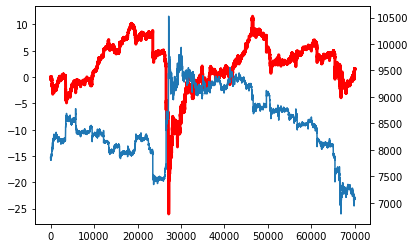

<Figure size 6000x6000 with 0 Axes>

test period= 2019-10-07 13:47:00  -  2019-11-25 04:27:00
total pl=1.568799999999995,num trade=393,win rate=0.7634, pl_stability=35.3976, num_buy=185, num_sell=208
strategy performance=55.53175487999982


In [47]:
'''
conti sim
'''

import time
num_term = 5
corr_kijun = 0.7
upper_kijun = 0.5
#lower_kijun = 0.4
from_ind = 40000
to_ind = 144000

train_len = 30000
test_len = 70000
test_start_ind = 30000 #should be larger than train_len
valid_size = 0.4

kijun_val =50   
kijun_period = 120
pt = kijun_val
lc = 10000

params = {'objective': 'multiclass', 'num_class':4, 'metric':'multi_logloss', 'boosting': 'gbdt', 'learning_rate': 0.1, 'num_iterations': 500, 'device_type':'GPU',
          'max_depth':10, 'num_leaves':50, 'early_stopping_rounds':50, 'lambda_l1':15, 'lambda_l2':15, 'min_data_in_leaf':50, 'max_bin':100, 'bagging_freq':50}

cat_params = {'task_type': 'GPU','verbose': True, 'loss_function':'MultiClass', 'num_boost_round':1000, 'early_stopping_rounds':50, 'depth':10, 'learning_rate':0.1}

start = time.time()
OneMinMarketData.initialize_for_bot(num_term, from_ind, to_ind, kijun_val, kijun_period)
df = OneMinMarketData.genrate_df_from_dict()
df = OneMinMarketData.remove_cols_contains_nan2(df)
#df = OneMinMarketData.remove_all_correlated_cols4(df, corr_kijun)
df2 = OneMinMarketData.remove_price_dependent_cols2(df, corr_kijun)

sim = Sim()
ac = SimAccount()
start_ind_log = 0
end_ind_log = 0

for i in range(1):
    lgbmodel = LgbModel()
    catmodel = CatboostModel()
    train_df = df2.iloc[test_start_ind - train_len + (test_len * i):(test_len * i) + test_start_ind]
    test_df = df2.iloc[kijun_period + (test_len * i) + test_start_ind:kijun_period + test_start_ind + (test_len * i) + test_len]
    print('generating bpsp data2')
    train_xb, test_xb, train_yb, test_yb, valid_xb, valid_yb = lgbmodel.generate_bpsp_data2(train_df, test_df, valid_size)
    
    cols = list(train_xb.columns)
    remove_cols = ['open', 'high', 'low', 'close', 'open_change', 'high_change' , 'low_change', 'close_change', 'dt']

    for col in remove_cols:
        if col in cols:
            cols.remove(col)
    cols.sort()
    train_xb = train_xb.loc[:,cols]
    test_xb = test_xb.loc[:,cols]
    valid_xb = valid_xb.loc[:,cols]
    print('removed unsed index')

    if list(train_xb.columns) == list(test_xb.columns) == list(valid_xb.columns):
        pass
    else:
        print('train col, test col, valid col are not matched!')

    model = lgbmodel.train_params_with_validations(train_xb, train_yb, valid_xb, valid_yb, params)
    #model = catmodel.param_train(train_xb, train_yb, cat_params)
    prediction = lgbmodel.bpsp_prediction(model, train_xb, upper_kijun)
    #prediction = lgbmodel.bpsp_prediction2(model, train_xb)
    #prediction = catmodel.predict(model, train_xb, train_yb)
    print('train accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, train_yb)))
    prediction = lgbmodel.bpsp_prediction(model, test_xb, upper_kijun)
    #prediction = lgbmodel.bpsp_prediction2(model, test_xb)
    #prediction = catmodel.predict(model, test_xb, test_yb)
    print('test accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, test_yb)))

    start_ind = OneMinMarketData.check_matched_dt(test_xb, df2)
    ac = sim.sim_model_pred_onemin(start_ind, prediction, pt, lc, ac)
    print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
    print('strategy performance={}'.format(ac.total_pl * ac.pl_stability))

    if i is 0:
        start_ind_log = start_ind
    else:
        end_ind_log = start_ind

if end_ind_log is 0:
    end_ind_log = start_ind_log

with open('/content/drive/My Drive/Model/bpsp_cols.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerow(train_xb)

with open('/content/drive/My Drive/Model/lgb_bpsp_model.dat', 'wb') as f:
    pickle.dump(model, f)

fig, ax1 = plt.subplots()
plt.figure(figsize=(30,30),dpi=200)
ax1.plot(ac.performance_total_pl_log,color='red',linewidth = 3.0,label='pl')
ax2 = ax1.twinx()
ax2.plot(OneMinMarketData.ohlc.close[start_ind_log:end_ind_log + test_len])
plt.show()
print('test period=', OneMinMarketData.ohlc.dt[start_ind_log], ' - ', OneMinMarketData.ohlc.dt[end_ind_log + test_len])
print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
print('strategy performance={}'.format(ac.total_pl * ac.pl_stability))

In [40]:
importance = pd.DataFrame(model.feature_importance(), index=list(train_xb.columns), columns=['importance'])
importance.sort_values('importance', ascending=False)[:50]

,importance
aroon_os:902,122
dx:25,95
williams_R:751,89
williams_R:525,84
correl:75,81
correl:1034,76
williams_R:1450,74
aroon_os:100,74
aroon_os:95,73
dx:20,70


In [43]:
OneMinMarketData.term_list[-1]

1450

total pl=4.1505,num trade=602,win rate=0.7093, pl_stability=11.012, num_buy=291, num_sell=311
strategy performance=45.705306


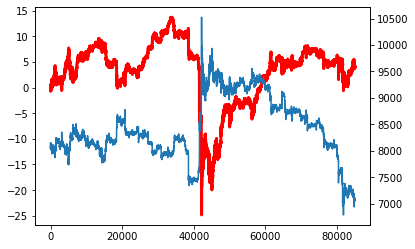

<Figure size 6000x6000 with 0 Axes>

test period= 2019-09-27 03:47:00  -  2019-11-25 04:27:00
total pl=4.1505,num trade=602,win rate=0.7093, pl_stability=11.012, num_buy=291, num_sell=311
strategy performance=45.705306


In [42]:
sim = Sim()
ac = SimAccount()
ac = sim.sim_model_pred_onemin(start_ind, prediction, pt, lc, ac)
print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
print('strategy performance={}'.format(ac.total_pl * ac.pl_stability))

if i is 0:
    start_ind_log = start_ind
else:
    end_ind_log = start_ind

if end_ind_log is 0:
    end_ind_log = start_ind_log

with open('/content/drive/My Drive/Model/bpsp_cols.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerow(train_xb)

with open('/content/drive/My Drive/Model/lgb_bpsp_model.dat', 'wb') as f:
    pickle.dump(model, f)

fig, ax1 = plt.subplots()
plt.figure(figsize=(30,30),dpi=200)
ax1.plot(ac.performance_total_pl_log,color='red',linewidth = 3.0,label='pl')
ax2 = ax1.twinx()
ax2.plot(OneMinMarketData.ohlc.close[start_ind_log:end_ind_log + test_len])
plt.show()
print('test period=', OneMinMarketData.ohlc.dt[start_ind_log], ' - ', OneMinMarketData.ohlc.dt[end_ind_log + test_len])
print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
print('strategy performance={}'.format(ac.total_pl * ac.pl_stability))

In [0]:

cut_size = OneMinMarketData.term_list[-1] + 1
end = len(OneMinMarketData.ohlc.close) - OneMinMarketData.kijun_period #due to bpsp
OneMinMarketData.ohlc.index_data_dict['dt'] = OneMinMarketData.ohlc.dt
OneMinMarketData.ohlc.index_data_dict['size'] = OneMinMarketData.ohlc.size
OneMinMarketData.ohlc.index_data_dict['close'] = OneMinMarketData.ohlc.close
df = pd.DataFrame(OneMinMarketData.ohlc.index_data_dict)
'''
df = df.assign(dt=cls.ohlc.dt)
df = df.assign(open=cls.ohlc.open)
df = df.assign(high=cls.ohlc.high)
df = df.assign(low=cls.ohlc.low)
df = df.assign(close=cls.ohlc.close)
df = df.assign(open_change=cls.ohlc.open_change)
df = df.assign(high_change=cls.ohlc.high_change)
df = df.assign(low_change=cls.ohlc.low_change)
df = df.assign(close_change=cls.ohlc.close_change)
df = df.assign(size=cls.ohlc.size)
'''
df = df.iloc[cut_size:end] 
df['future_side'] = OneMinMarketData.ohlc.future_side[cut_size:]
#df = df.assign(future_side=cls.ohlc.future_side[cut_size:])


In [0]:

cut_size = OneMinMarketData.term_list[-1] + 1
end = len(OneMinMarketData.ohlc.close) - OneMinMarketData.kijun_period #due to bpsp
OneMinMarketData.ohlc.index_data_dict['dt'] = OneMinMarketData.ohlc.dt
OneMinMarketData.ohlc.index_data_dict['size'] = OneMinMarketData.ohlc.size
OneMinMarketData.ohlc.index_data_dict['close'] = OneMinMarketData.ohlc.close
df2 = pd.DataFrame(OneMinMarketData.ohlc.index_data_dict)
'''
df = df.assign(dt=cls.ohlc.dt)
df = df.assign(open=cls.ohlc.open)
df = df.assign(high=cls.ohlc.high)
df = df.assign(low=cls.ohlc.low)
df = df.assign(close=cls.ohlc.close)
df = df.assign(open_change=cls.ohlc.open_change)
df = df.assign(high_change=cls.ohlc.high_change)
df = df.assign(low_change=cls.ohlc.low_change)
df = df.assign(close_change=cls.ohlc.close_change)
df = df.assign(size=cls.ohlc.size)
'''
df2 = df2.iloc[cut_size:end] 
#df['future_side'] = OneMinMarketData.ohlc.future_side[cut_size:]
df2 = df2.assign(future_side=OneMinMarketData.ohlc.future_side[cut_size:])

In [21]:
type(datetime.now().minute)

int

In [0]:
from collections import deque
q = deque()